<a href="https://colab.research.google.com/github/MillionHappa/Spark/blob/main/Spark%2B_%E6%8E%A1%E7%94%A8%E8%AA%B2%E9%A1%8C_1_ipynb_%E3%81%AE%E3%82%B3%E3%83%94%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#データのimport



In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms, models
from torchvision.models import resnet50, ResNet50_Weights
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from PIL import Image

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    roc_curve,
    ConfusionMatrixDisplay,
    RocCurveDisplay
)

import seaborn as sns

import torch.nn.functional as F

from sklearn.preprocessing import label_binarize

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


#モデルの選定

In [ ]:
#conv1をcifar10のサイズに合わせて変更
def get_cifar10_resnet50():
    model = resnet50(weights=ResNet50_Weights.DEFAULT) #pretrained=Trueと同じ
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, 10) #10クラス分類のため
    return model

model = get_cifar10_resnet50().to(device)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 217MB/s]


#Data Augmentation

#Combination


#Basic

##Basic Standard

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float()).item()

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)

        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()).item()

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

epoch: 0, loss: 0.626046642527623, acc: 0.7806301983365324, val loss: 0.2782448381066513, val acc: 0.9051517571884984
epoch: 1, loss: 0.2013997597219476, acc: 0.931182021753039, val loss: 0.21103612520395756, val acc: 0.9277156549520766
epoch: 2, loss: 0.09204560897675934, acc: 0.9687300063979527, val loss: 0.2034469213427458, val acc: 0.9347044728434505
epoch: 3, loss: 0.05465976055231099, acc: 0.9809061100447857, val loss: 0.2223278537917787, val acc: 0.9302116613418531
epoch: 4, loss: 0.03947014300217012, acc: 0.986724248240563, val loss: 0.20936381374113858, val acc: 0.9368011182108626
epoch: 5, loss: 0.027841768086150822, acc: 0.9907629558541267, val loss: 0.224669073322288, val acc: 0.9370007987220448
epoch: 6, loss: 0.019480186604563215, acc: 0.9936020473448497, val loss: 0.20607399045905922, val acc: 0.943091054313099
epoch: 7, loss: 0.020533645941281844, acc: 0.9929622520793346, val loss: 0.22942280738180082, val acc: 0.9385982428115016
epoch: 8, loss: 0.021576033200339573, ac

Accuracy: 0.9407

Classification Report:
               precision    recall  f1-score   support

       plane     0.9652    0.9150    0.9394      1000
         car     0.9594    0.9680    0.9637      1000
        bird     0.9051    0.9350    0.9198      1000
         cat     0.8663    0.9070    0.8862      1000
        deer     0.9291    0.9570    0.9429      1000
         dog     0.9246    0.8710    0.8970      1000
        frog     0.9611    0.9630    0.9620      1000
       horse     0.9745    0.9550    0.9646      1000
        ship     0.9679    0.9650    0.9664      1000
       truck     0.9595    0.9710    0.9652      1000

    accuracy                         0.9407     10000
   macro avg     0.9413    0.9407    0.9407     10000
weighted avg     0.9413    0.9407    0.9407     10000



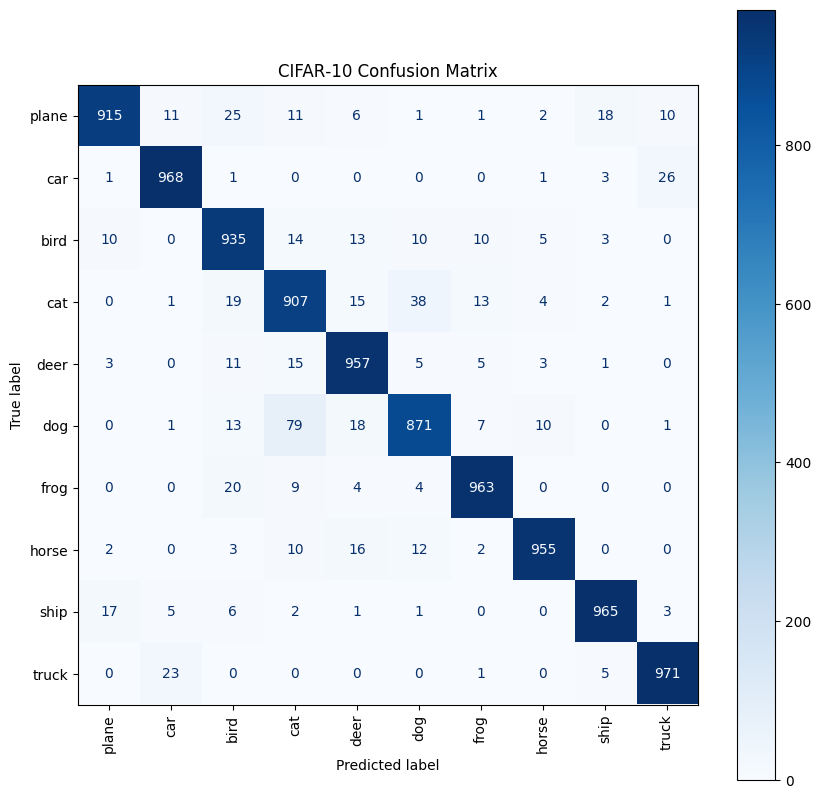

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.show()


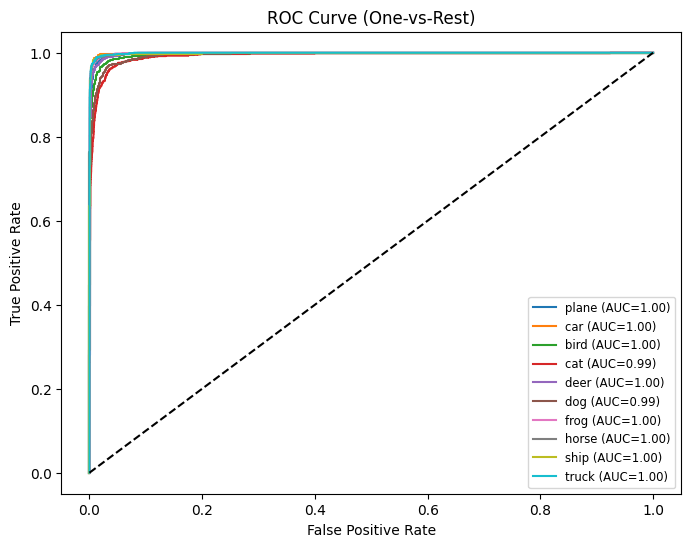

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.show()

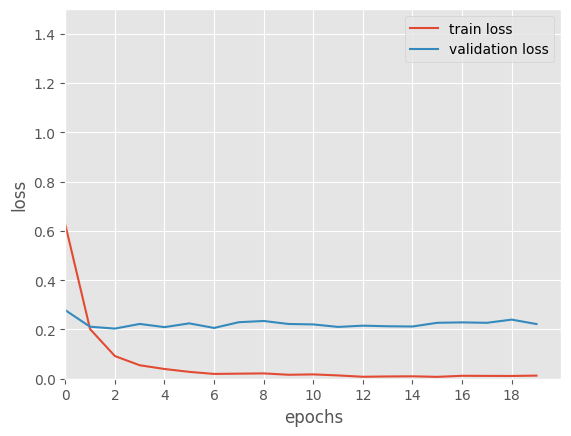

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,1.5)
plt.xticks(range(0, 19, 2))
plt.legend()

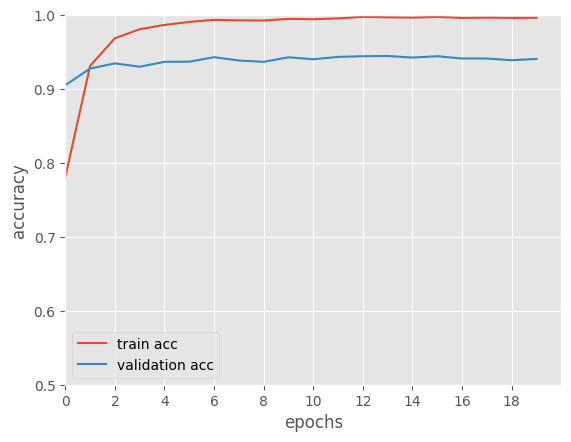

In [ ]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0,20)
plt.ylim(0.5,1)
plt.xticks(range(0, 19, 2))
plt.legend()

## Basic Preprocessing

In [ ]:
class gcn():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ


# 標準化後の画像を[0, 1]に正規化する
def deprocess(x):
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    return _x

In [ ]:
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        x = images[0][0].reshape(1, -1)  # 画像（1枚）を1次元化
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)  # 平均値を格納するテンソル．xと同じ形状
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        # E: 固有値 V: 固有ベクトルを並べたもの
        E, V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())  # A(\Lambda + \epsilon I)^{1/2}A^T
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean  # x - \bar{x}
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x

zca = ZCAWhitening()
raw_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
zca.fit(raw_dataset)

GCN = gcn()

train_transform = transforms.Compose([
    transforms.ToTensor(),
    GCN,
    zca,
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    GCN,
    zca,
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

100%|██████████| 170M/170M [00:12<00:00, 13.3MB/s]


0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float()).item()

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)

        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()).item()

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

epoch: 0, loss: 0.09729430119077105, acc: 0.967530369758606, val loss: 0.2508856997209283, val acc: 0.925319492816925
epoch: 1, loss: 0.040565128803015355, acc: 0.9863843321800232, val loss: 0.24293454754100843, val acc: 0.9309105277061462
epoch: 2, loss: 0.026529542598224265, acc: 0.9911628365516663, val loss: 0.24972515610290674, val acc: 0.9292132258415222
epoch: 3, loss: 0.01689708925173273, acc: 0.9948016405105591, val loss: 0.27226867539117844, val acc: 0.9274161458015442
epoch: 4, loss: 0.013243609404706454, acc: 0.9958213567733765, val loss: 0.25267326157315434, val acc: 0.9353035092353821
epoch: 5, loss: 0.011707462598813247, acc: 0.996141254901886, val loss: 0.25229323779815993, val acc: 0.9355031847953796
epoch: 6, loss: 0.015322819768669442, acc: 0.9949415922164917, val loss: 0.248489353870032, val acc: 0.9376996755599976
epoch: 7, loss: 0.009125699645173893, acc: 0.9970609545707703, val loss: 0.2290566195696652, val acc: 0.9418929815292358
epoch: 8, loss: 0.011023387068732

Accuracy: 0.9372

Classification Report:
               precision    recall  f1-score   support

       plane     0.9538    0.9300    0.9418      1000
         car     0.9596    0.9740    0.9667      1000
        bird     0.9467    0.9230    0.9347      1000
         cat     0.8549    0.8720    0.8634      1000
        deer     0.9178    0.9600    0.9384      1000
         dog     0.9104    0.8840    0.8970      1000
        frog     0.9585    0.9480    0.9532      1000
       horse     0.9665    0.9520    0.9592      1000
        ship     0.9457    0.9760    0.9606      1000
       truck     0.9607    0.9530    0.9568      1000

    accuracy                         0.9372     10000
   macro avg     0.9375    0.9372    0.9372     10000
weighted avg     0.9375    0.9372    0.9372     10000



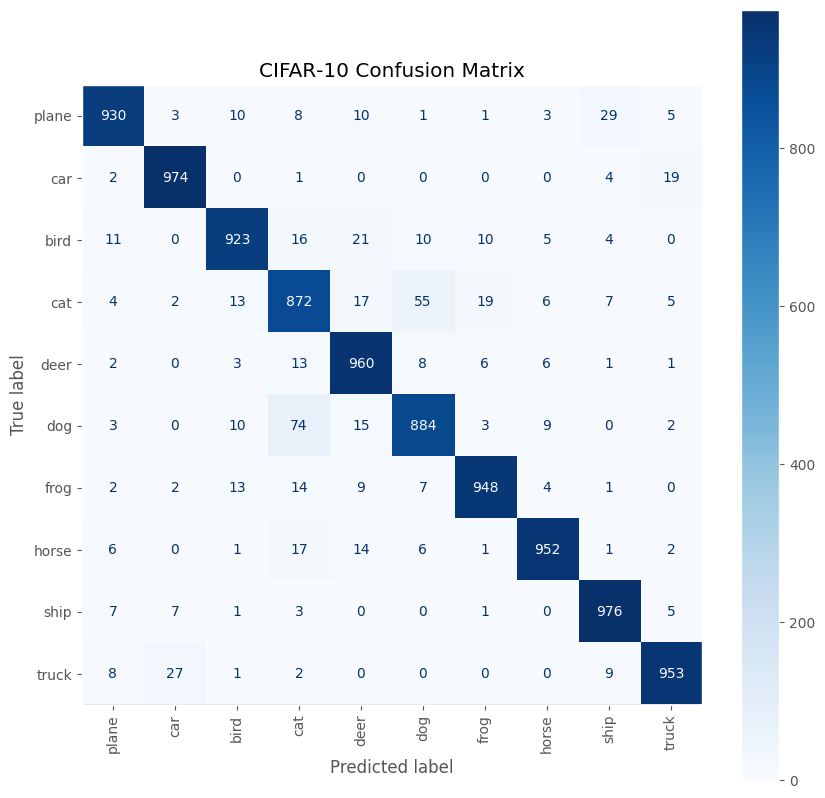

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.grid(False)
plt.show()


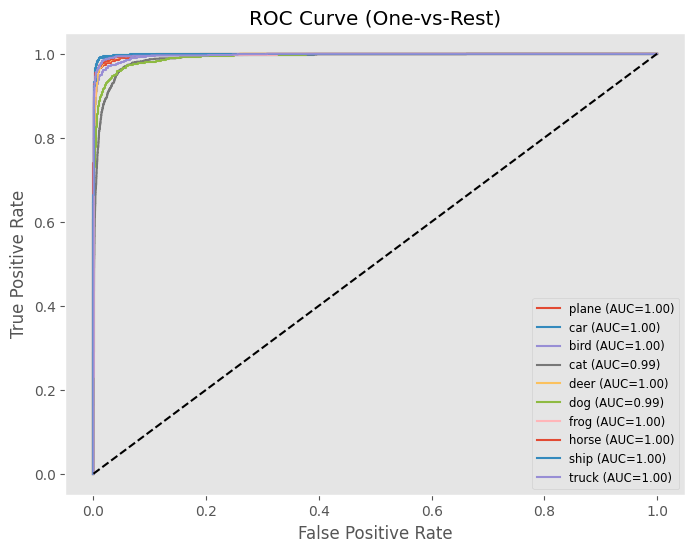

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(False)
plt.show()

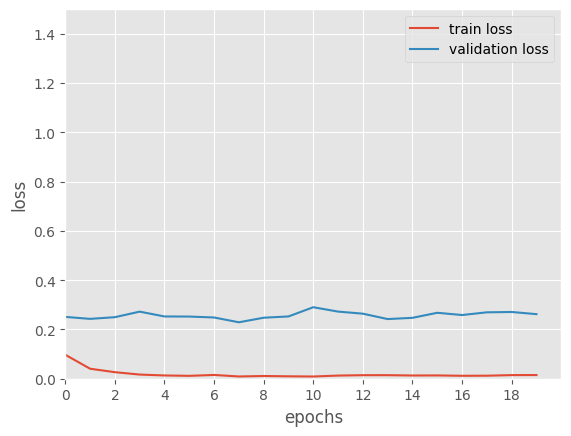

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,1.5)
plt.xticks(range(0, 19, 2))
plt.legend()

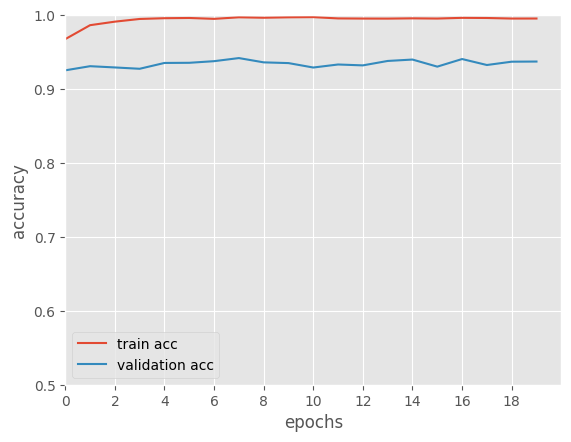

In [ ]:
plt.plot([accs_.cpu() for accs_ in accs], label="train acc")
plt.plot([accs_.cpu() for accs_ in val_accs], label="validation acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0,20)
plt.ylim(0.5,1)
plt.xticks(range(0, 19, 2))
plt.legend()

## Basic Preprocessing without Normalization

In [ ]:
class gcn():
    def __init__(self):
        pass

    def __call__(self, x):
        mean = torch.mean(x)
        std = torch.std(x)
        return (x - mean)/(std + 10**(-6))  # 0除算を防ぐ


# 標準化後の画像を[0, 1]に正規化する
def deprocess(x):
    _min = np.min(x)
    _max = np.max(x)
    _x = (x - _min)/(_max - _min)
    return _x

In [ ]:
class ZCAWhitening():
    def __init__(self, epsilon=1e-4, device="cuda"):
        self.epsilon = epsilon
        self.device = device

    def fit(self, images):  # 変換行列と平均をデータから計算
        x = images[0][0].reshape(1, -1)  # 画像（1枚）を1次元化
        self.mean = torch.zeros([1, x.size()[1]]).to(self.device)  # 平均値を格納するテンソル．xと同じ形状
        con_matrix = torch.zeros([x.size()[1], x.size()[1]]).to(self.device)
        for i in range(len(images)):  # 各データについての平均を取る
            x = images[i][0].reshape(1, -1).to(self.device)
            self.mean += x / len(images)
            con_matrix += torch.mm(x.t(), x) / len(images)
            if i % 10000 == 0:
                print("{0}/{1}".format(i, len(images)))
        con_matrix -= torch.mm(self.mean.t(), self.mean)
        # E: 固有値 V: 固有ベクトルを並べたもの
        E, V = torch.linalg.eigh(con_matrix)  # 固有値分解
        self.ZCA_matrix = torch.mm(torch.mm(V, torch.diag((E.squeeze()+self.epsilon)**(-0.5))), V.t())  # A(\Lambda + \epsilon I)^{1/2}A^T
        print("completed!")

    def __call__(self, x):
        size = x.size()
        x = x.reshape(1, -1).to(self.device)
        x -= self.mean  # x - \bar{x}
        x = torch.mm(x, self.ZCA_matrix.t())
        x = x.reshape(tuple(size))
        x = x.to("cpu")
        return x

zca = ZCAWhitening()
raw_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
zca.fit(raw_dataset)

GCN = gcn()

train_transform = transforms.Compose([
    transforms.ToTensor(),
    GCN,
    zca
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    GCN,
    zca
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

0/50000
10000/50000
20000/50000
30000/50000
40000/50000
completed!


In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float()).item()

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)

        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()).item()

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

epoch: 0, loss: 0.5443496177460395, acc: 0.8138595649392194, val loss: 0.28495791159308376, val acc: 0.9065495207667732
epoch: 1, loss: 0.1785080301928705, acc: 0.9390395073576455, val loss: 0.25731190143170923, val acc: 0.9220247603833865
epoch: 2, loss: 0.08494418034236462, acc: 0.9705294305822136, val loss: 0.31733150148880296, val acc: 0.9207268370607029
epoch: 3, loss: 0.04961241222690864, acc: 0.9830854126679462, val loss: 0.24515413536657446, val acc: 0.9352036741214057
epoch: 4, loss: 0.038997874818344914, acc: 0.9862843889955214, val loss: 0.22050577998548127, val acc: 0.9354033546325878
epoch: 5, loss: 0.027904254980036354, acc: 0.9911628278950736, val loss: 0.22099468211558596, val acc: 0.9389976038338658
epoch: 6, loss: 0.019971181582928734, acc: 0.9934221049264236, val loss: 0.23247277218113527, val acc: 0.9377995207667732
epoch: 7, loss: 0.01719693706475407, acc: 0.994321817018554, val loss: 0.21845368236919252, val acc: 0.9425918530351438
epoch: 8, loss: 0.01451394354099

Accuracy: 0.9333

Classification Report:
               precision    recall  f1-score   support

       plane     0.9112    0.9640    0.9368      1000
         car     0.9610    0.9610    0.9610      1000
        bird     0.9422    0.9130    0.9274      1000
         cat     0.8422    0.8910    0.8659      1000
        deer     0.9241    0.9490    0.9364      1000
         dog     0.9162    0.8420    0.8775      1000
        frog     0.9376    0.9760    0.9564      1000
       horse     0.9821    0.9330    0.9569      1000
        ship     0.9715    0.9540    0.9627      1000
       truck     0.9538    0.9500    0.9519      1000

    accuracy                         0.9333     10000
   macro avg     0.9342    0.9333    0.9333     10000
weighted avg     0.9342    0.9333    0.9333     10000



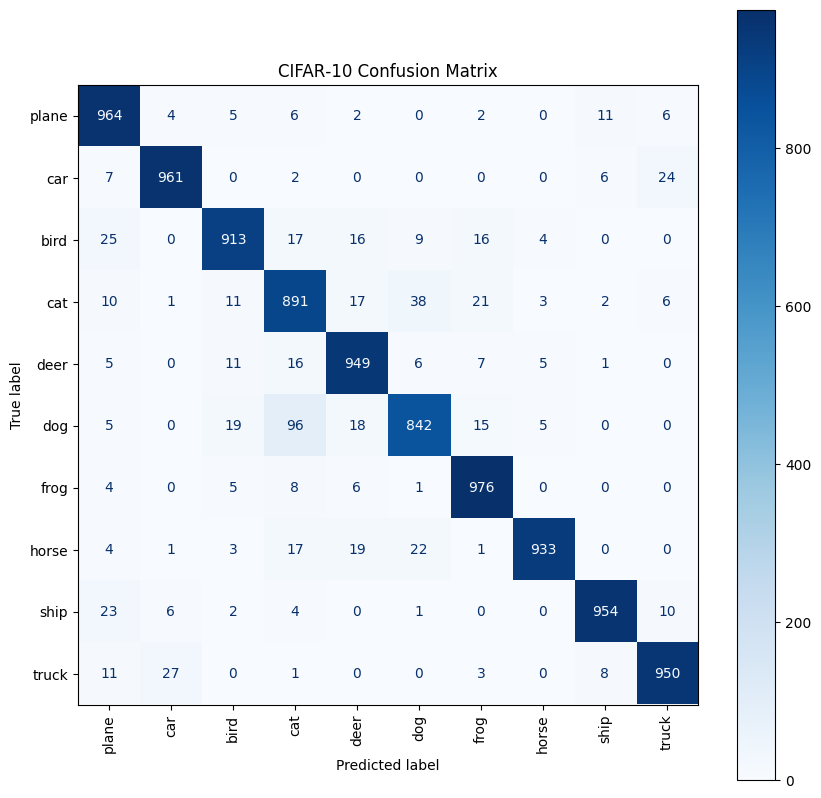

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.grid(False)
plt.show()


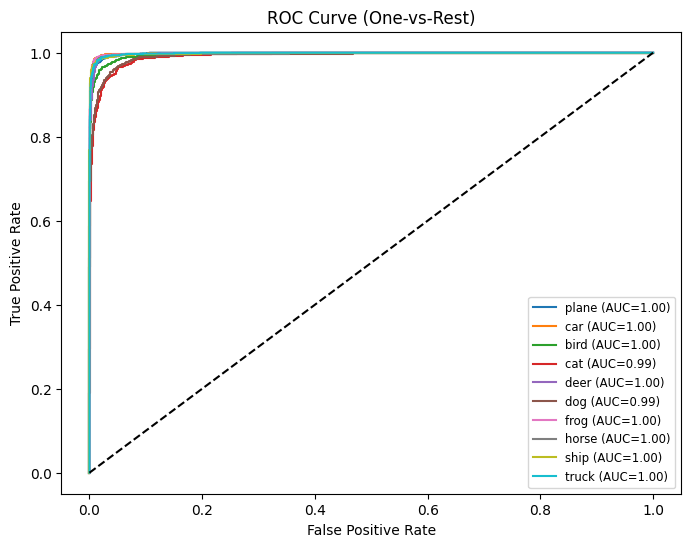

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.grid(False)
plt.show()

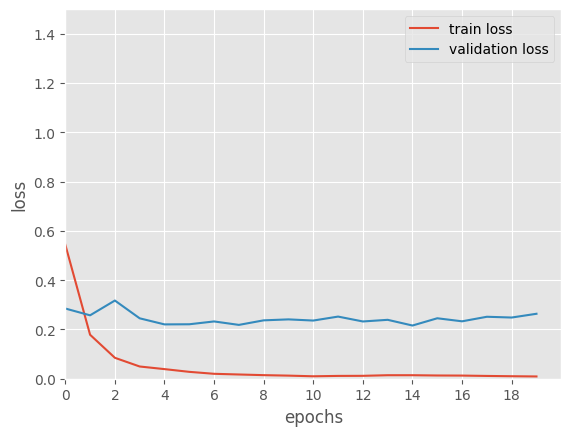

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,1.5)
plt.xticks(range(0, 19, 2))
plt.legend()

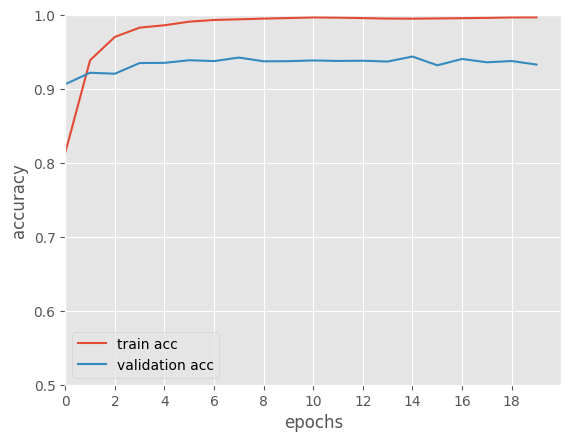

In [ ]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0,20)
plt.ylim(0.5,1)
plt.xticks(range(0, 19, 2))
plt.legend()

#Color Transformation

##Flip + Crop + Rotation + Gausian

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2023, 0.1994, 0.2010])
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],  # CIFAR-10の平均
                         std=[0.2023, 0.1994, 0.2010])   # CIFAR-10の標準偏差
])

raw_dataset =datasets.CIFAR10(root="./data", train=False, download=True, transform=None)
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
validation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=val_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [ ]:
names = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")
data_iter = iter(train_dataloader)
imgs, labels = next(data_iter)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

In [ ]:
num_epochs=20
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0

    for imgs, labels in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float()).item()

    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    accs.append(running_acc)

#validation
    model.eval()
    y_true, y_pred, y_score = [], [], []
    val_running_loss = 0.0
    val_running_acc = 0.0
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)

        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float()).item()

        probs = F.softmax(val_output, dim=1).cpu().detach().numpy()
        preds = np.argmax(probs, axis=1)

        y_true.extend(val_labels.cpu().numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    val_accs.append(val_running_acc)

    print("epoch: {}, loss: {}, acc: {}, val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

acc = accuracy_score(y_true, y_pred)
recall_macro = recall_score(y_true, y_pred, average='macro')
precision_macro = precision_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

print(f'Accuracy       : {acc:.4f}')
print(f'Precision (macro): {precision_macro:.4f}')
print(f'Recall (macro)   : {recall_macro:.4f}')
print(f'F1 Score (macro): {f1_macro:.4f}')

epoch: 0, loss: 0.903036478051221, acc: 0.6820217530390275, val loss: 0.3473071395612944, val acc: 0.8797923322683706
epoch: 1, loss: 0.3877739557306391, acc: 0.8694617722328855, val loss: 0.22413447047003543, val acc: 0.9237220447284346
epoch: 2, loss: 0.28813716032979053, acc: 0.9006118042226487, val loss: 0.1955715644235809, val acc: 0.931908945686901
epoch: 3, loss: 0.2337135604165032, acc: 0.9194257837492003, val loss: 0.1760596477221281, val acc: 0.941194089456869
epoch: 4, loss: 0.20393926405150656, acc: 0.9292226487523992, val loss: 0.16683574124185827, val acc: 0.9420926517571885
epoch: 5, loss: 0.17941156693395185, acc: 0.9378198976327575, val loss: 0.15431817928507638, val acc: 0.946685303514377
epoch: 6, loss: 0.1570874163836255, acc: 0.945677383237364, val loss: 0.14665492838203978, val acc: 0.9514776357827476
epoch: 7, loss: 0.14429856581233266, acc: 0.9495761356365963, val loss: 0.148123857543652, val acc: 0.952276357827476
epoch: 8, loss: 0.13408065708687794, acc: 0.953

Accuracy: 0.9498

Classification Report:
               precision    recall  f1-score   support

       plane     0.9745    0.9550    0.9646      1000
         car     0.9464    0.9890    0.9672      1000
        bird     0.9424    0.9490    0.9457      1000
         cat     0.8467    0.9280    0.8855      1000
        deer     0.9645    0.9510    0.9577      1000
         dog     0.9248    0.8860    0.9050      1000
        frog     0.9835    0.9510    0.9670      1000
       horse     0.9818    0.9700    0.9759      1000
        ship     0.9750    0.9770    0.9760      1000
       truck     0.9701    0.9420    0.9559      1000

    accuracy                         0.9498     10000
   macro avg     0.9510    0.9498    0.9500     10000
weighted avg     0.9510    0.9498    0.9500     10000



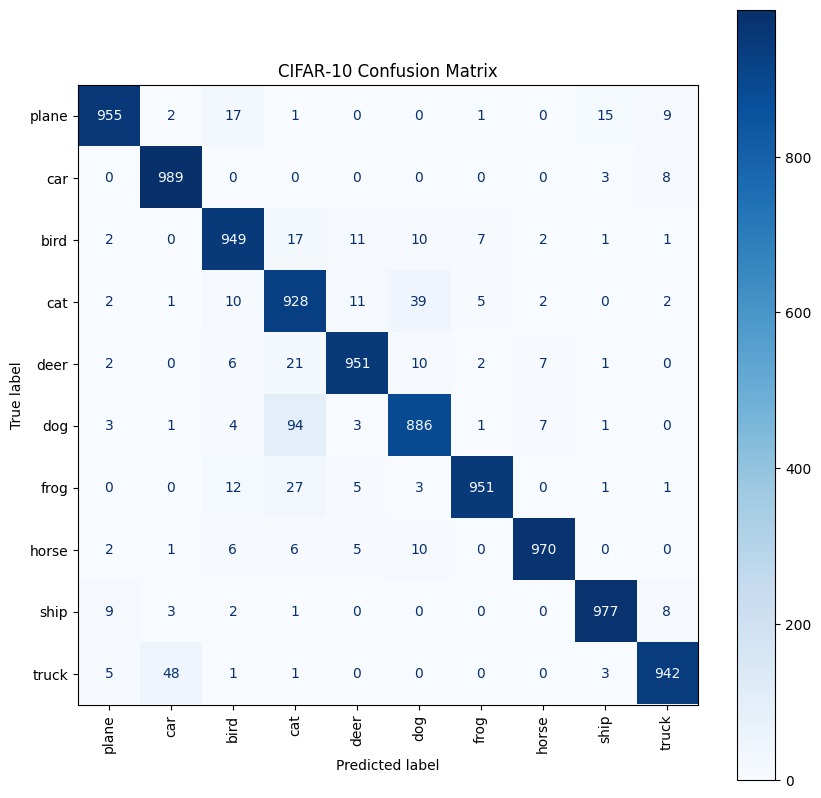

In [ ]:
# Accuracy
print("Accuracy:", accuracy_score(y_true, y_pred))

# Classification report (Precision／Recall／F1)
print("\nClassification Report:\n",
      classification_report(y_true, y_pred, target_names=names, digits=4))

# 混同行列の計算と可視化
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=names)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("CIFAR‑10 Confusion Matrix")
plt.grid(False)
plt.show()


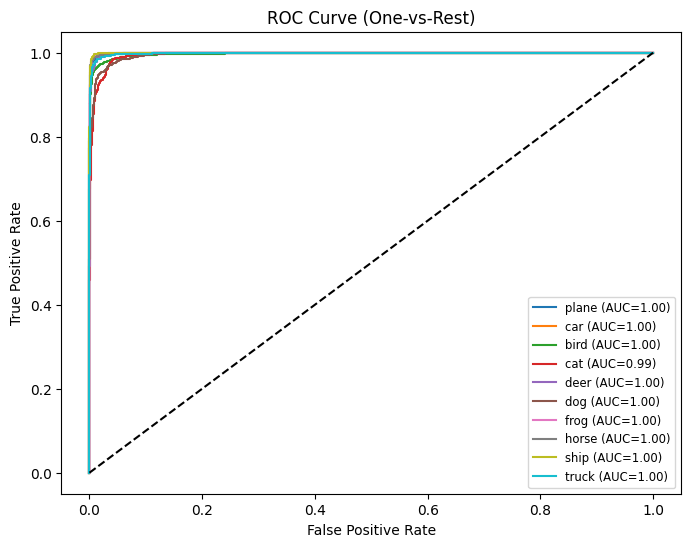

In [ ]:
# y_true を one-hot 表現に変換
y_true_bin = label_binarize(y_true, classes=list(range(10)))

# ROC 曲線・AUC
fpr, tpr, roc_auc = dict(), dict(), dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_true_bin[:, i], y_score[:, i])

# プロット
plt.figure(figsize=(8,6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'{names[i]} (AUC={roc_auc[i]:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right', fontsize='small')
plt.show()

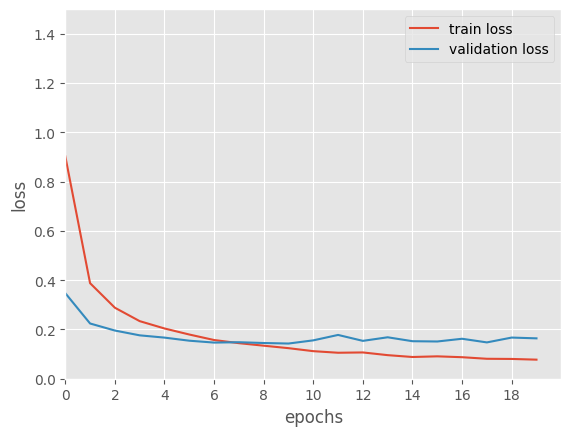

In [ ]:
plt.style.use("ggplot")
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.xlim(0,20)
plt.ylim(0,1.5)
plt.xticks(range(0, 19, 2))
plt.legend()

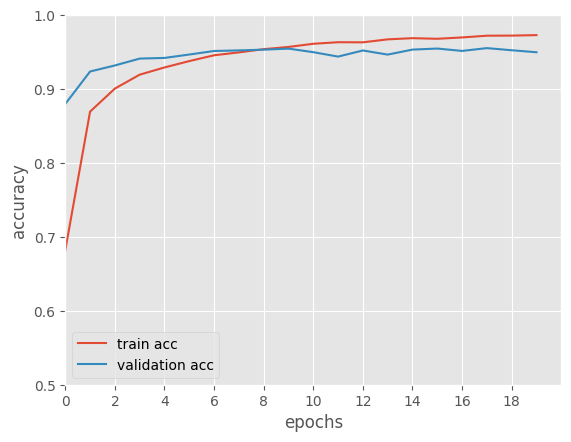

In [ ]:
plt.plot(accs, label="train acc")
plt.plot(val_accs, label="validation acc")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.xlim(0,20)
plt.ylim(0.5,1)
plt.xticks(range(0, 19, 2))
plt.legend()

[plane] - Misclassified: 45


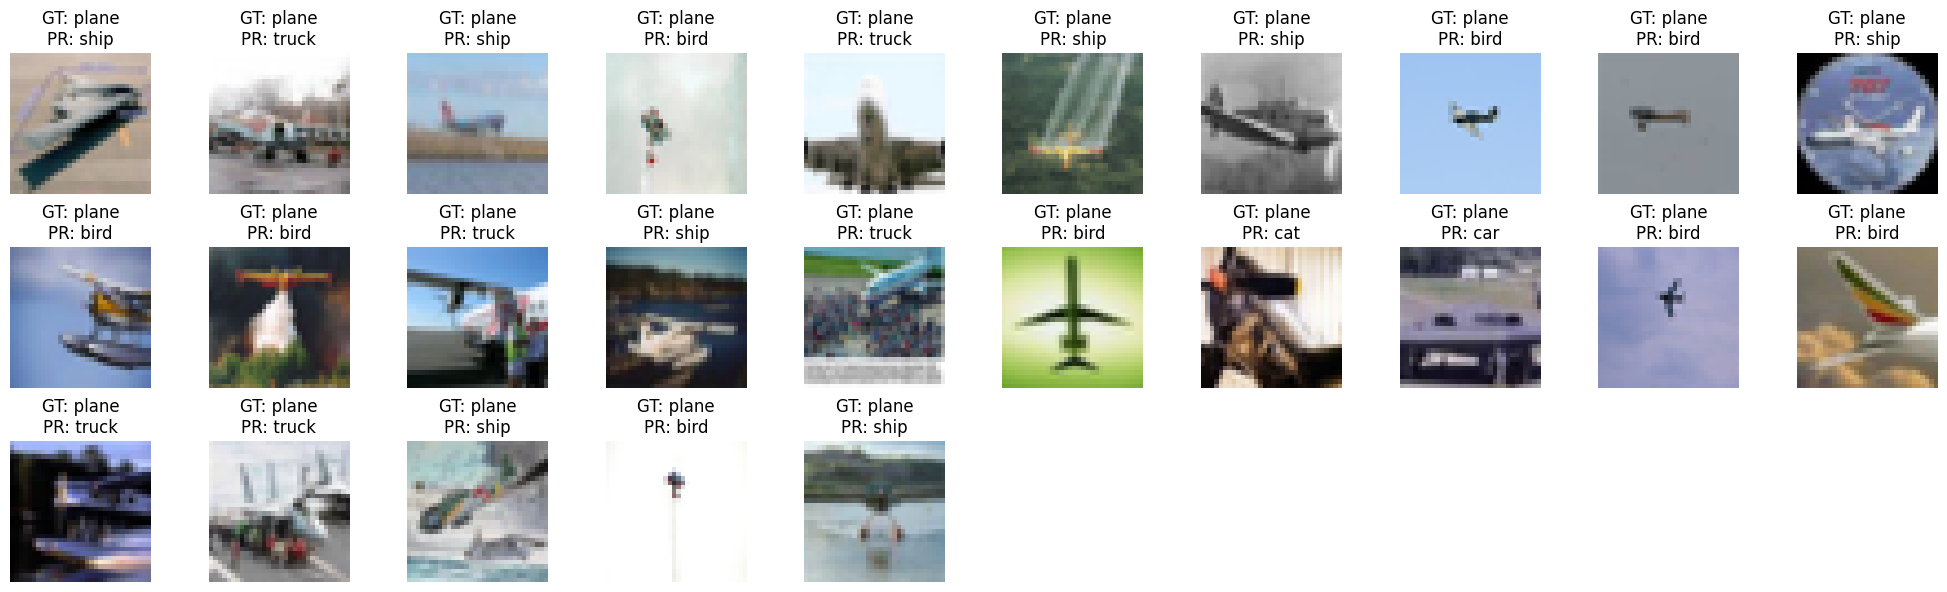

[car] - Misclassified: 11


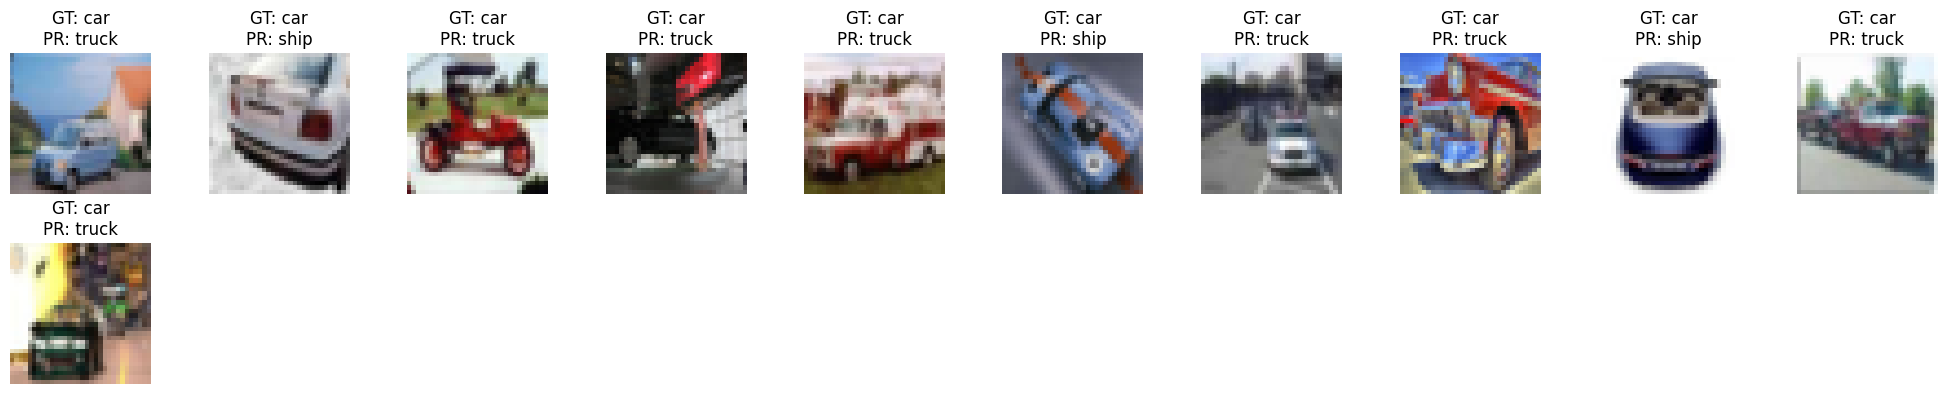

[bird] - Misclassified: 51


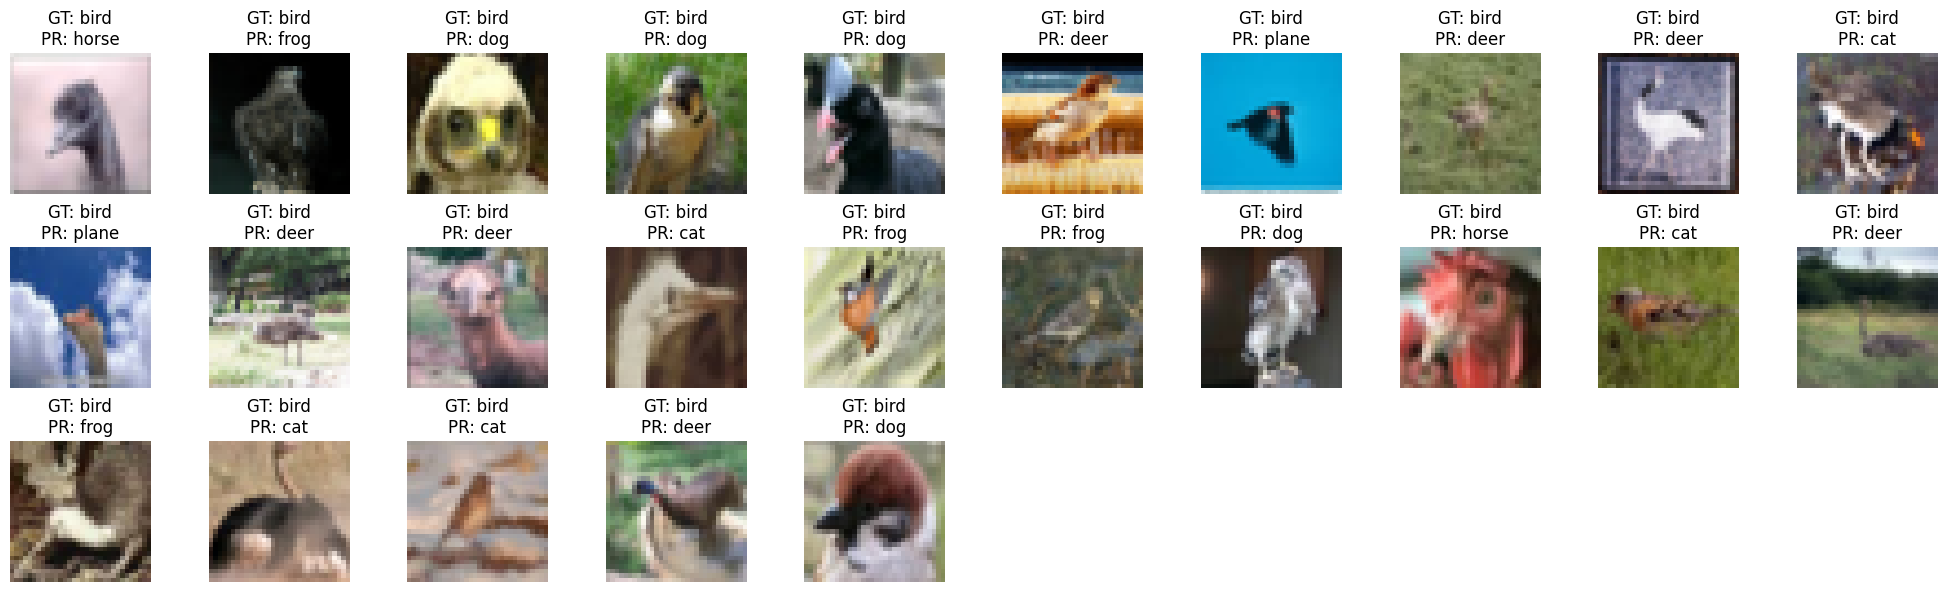

[cat] - Misclassified: 72


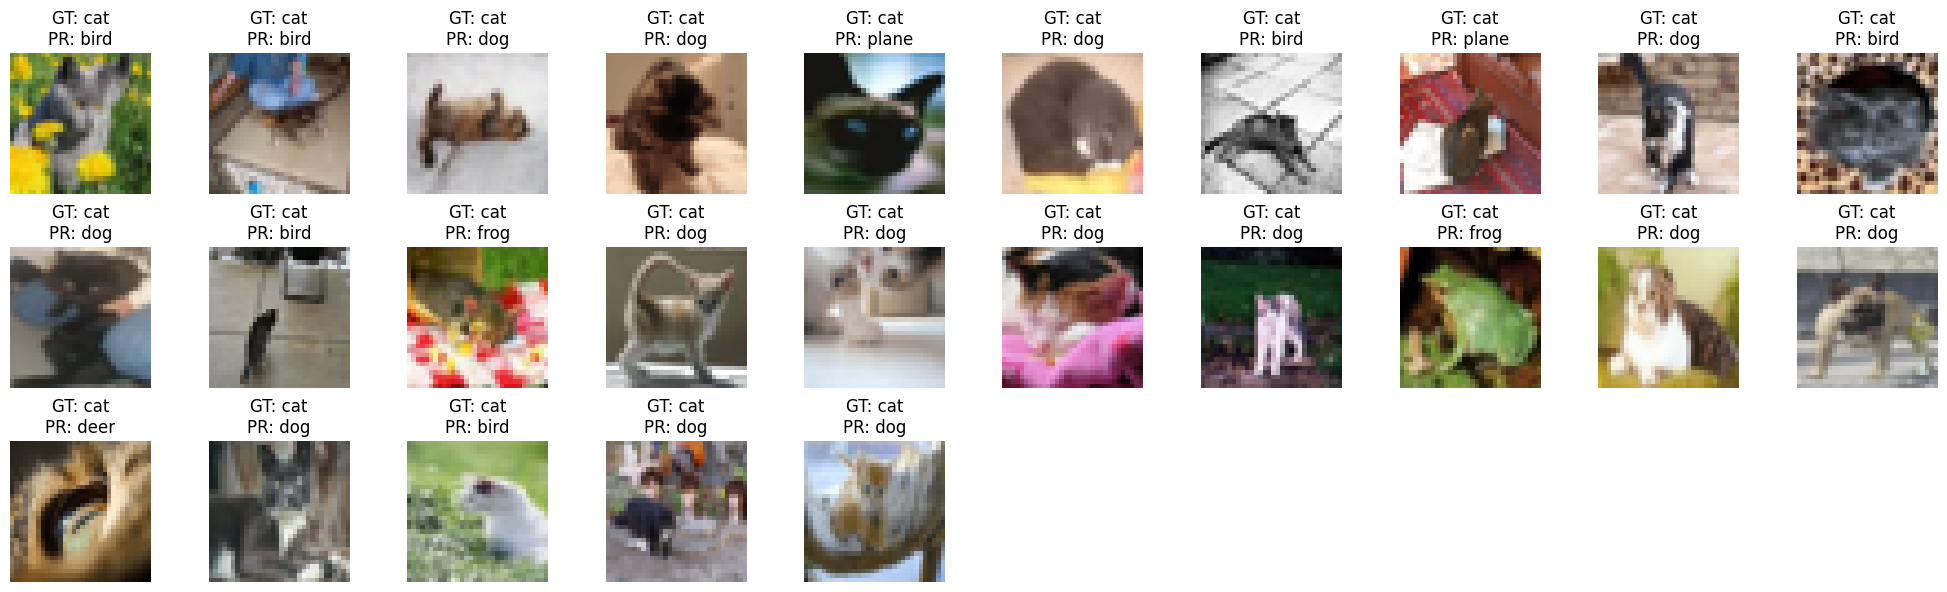

[deer] - Misclassified: 49


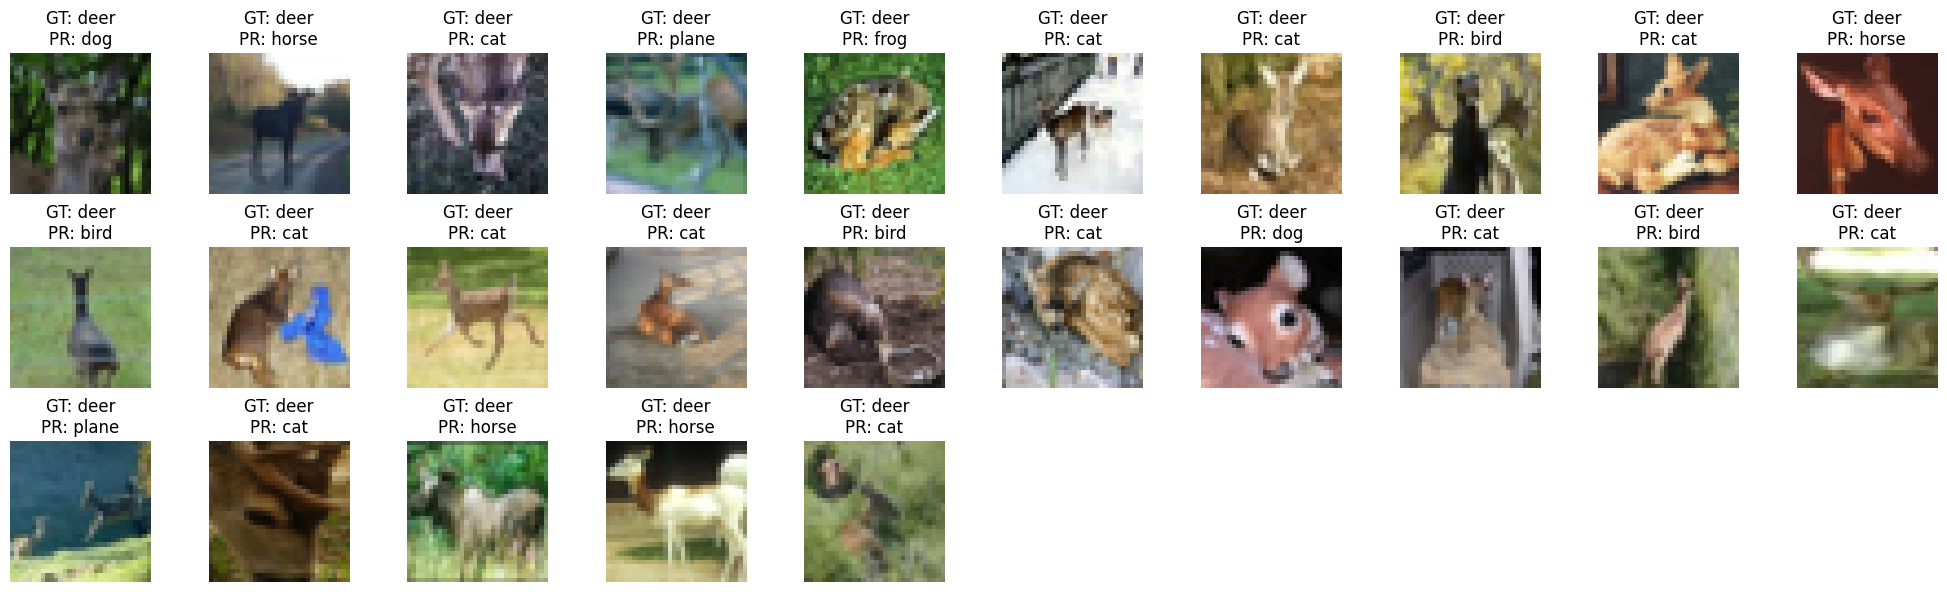

[dog] - Misclassified: 114


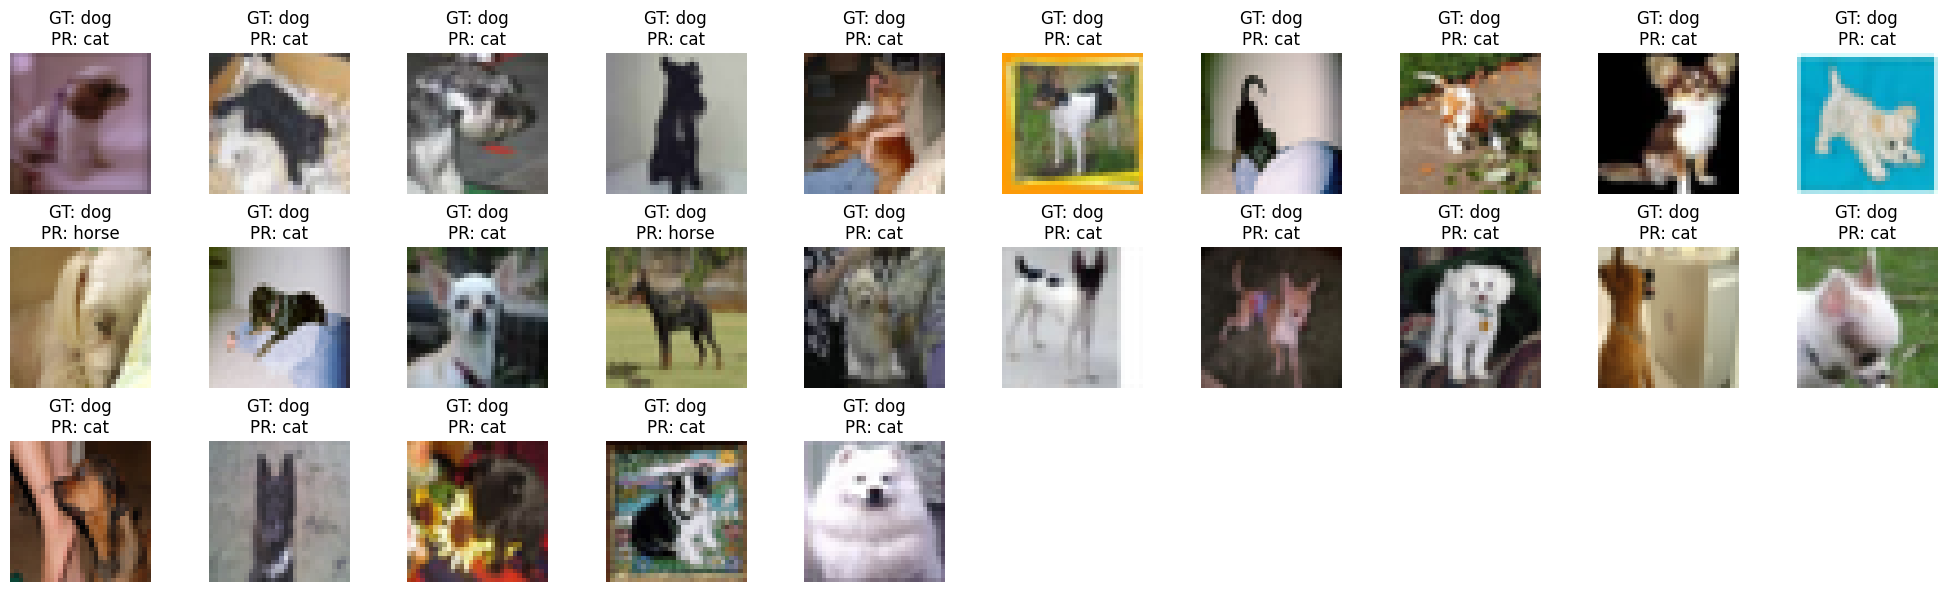

[frog] - Misclassified: 49


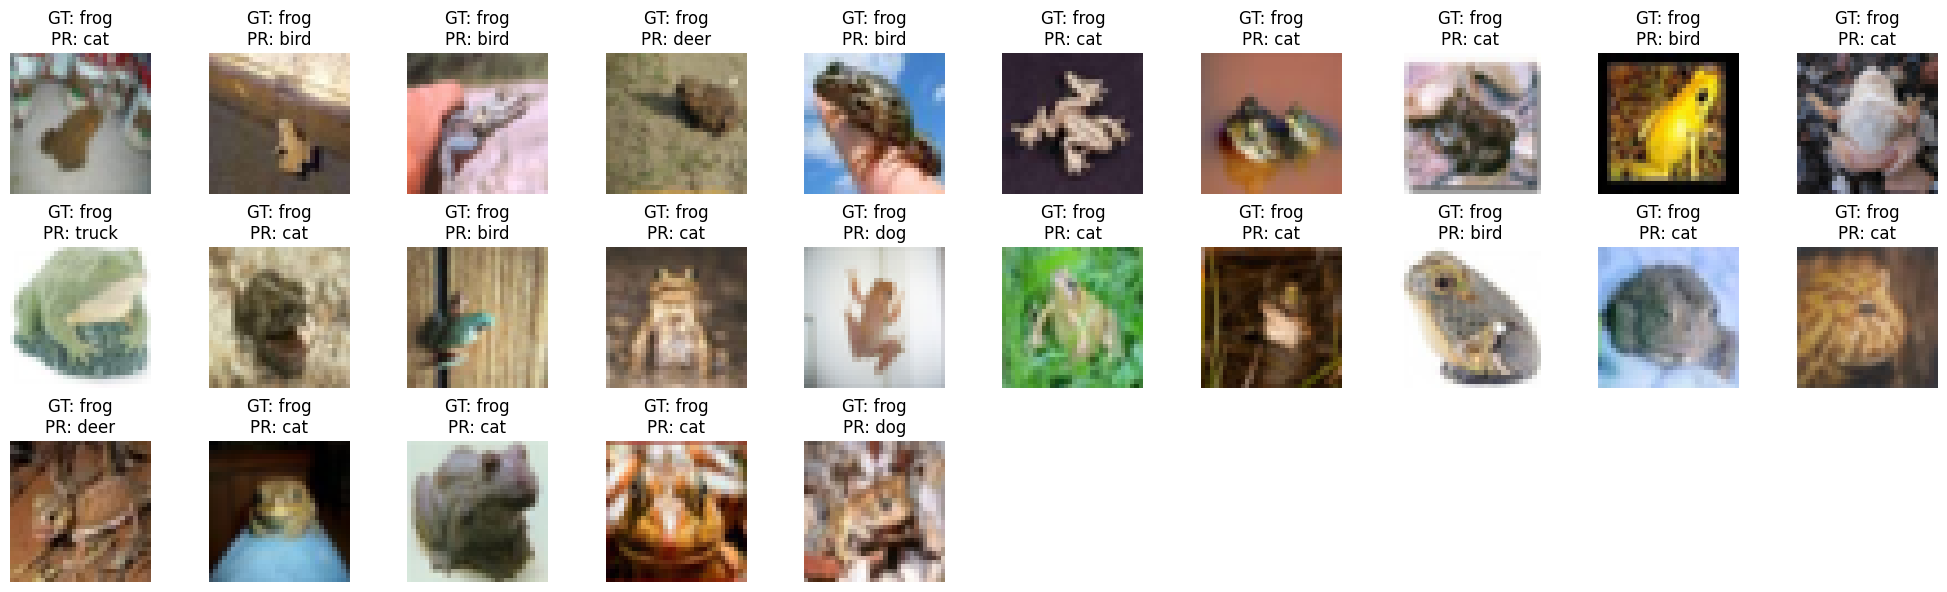

[horse] - Misclassified: 30


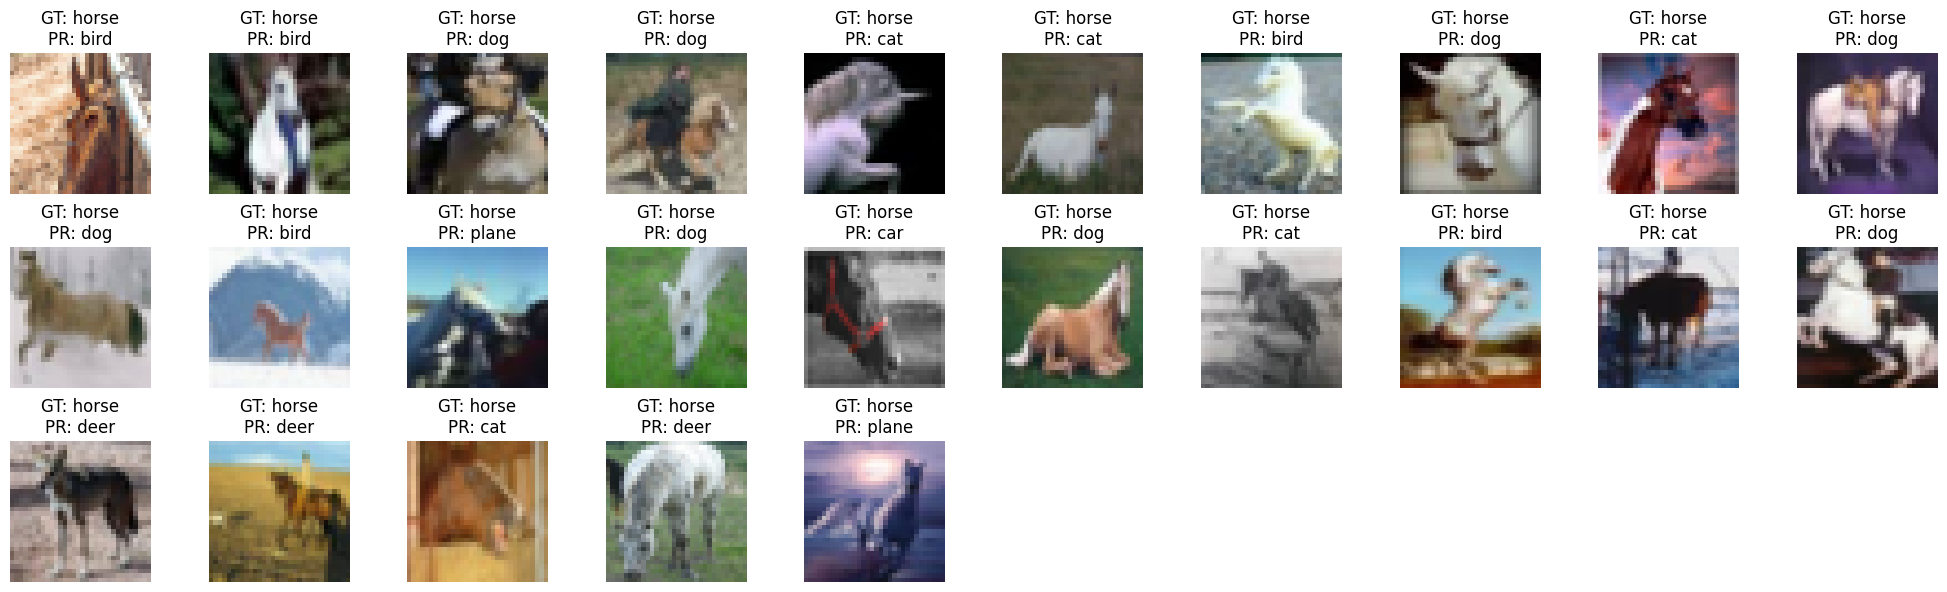

[ship] - Misclassified: 23


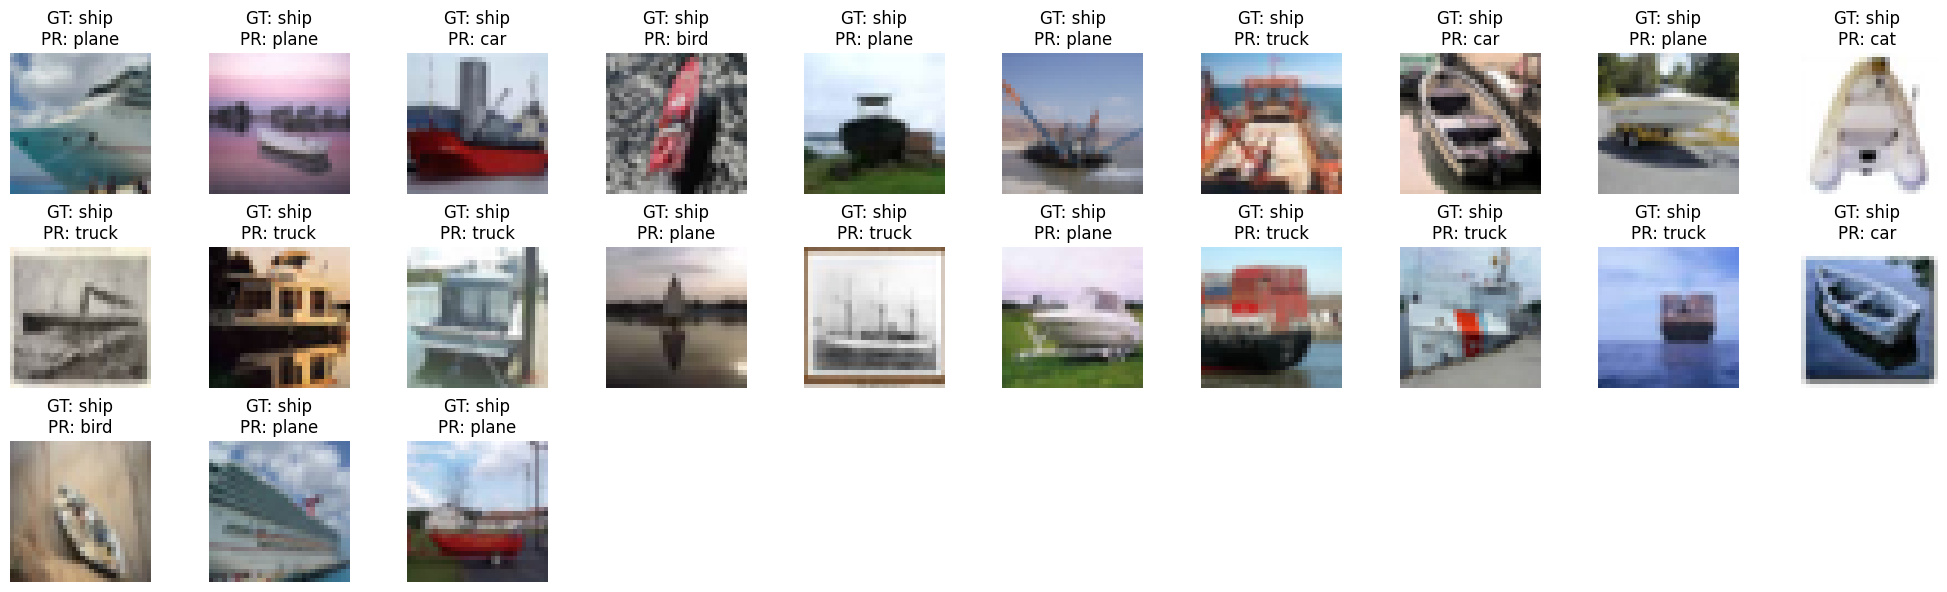

[truck] - Misclassified: 58


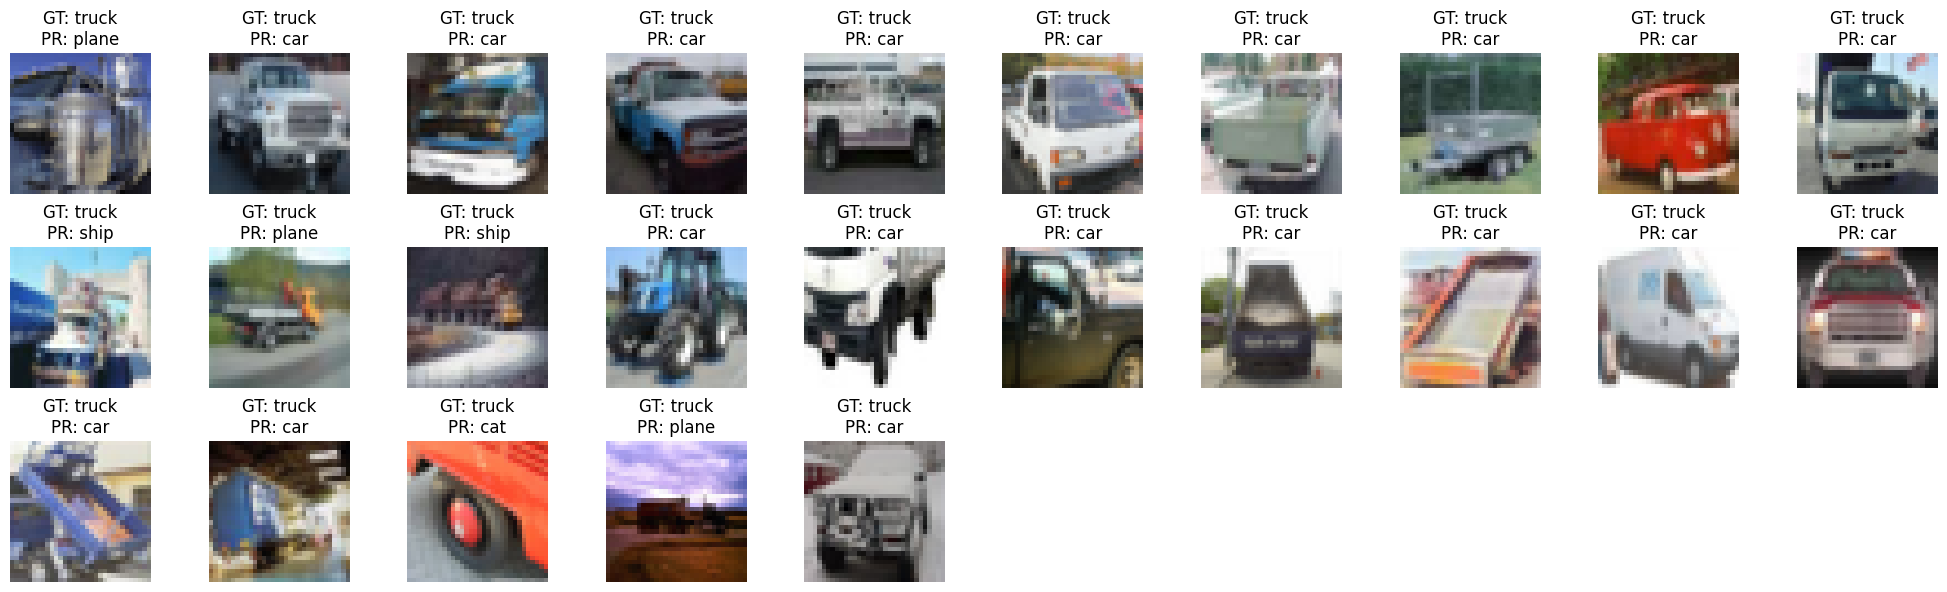

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# CIFAR-10クラスラベル
classes = ["plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

def show_misclassified_images_by_label(dataset, y_true, y_pred, label_id, max_images=25):
    """
    指定したラベルID（例: 3=cat）の誤分類画像を最大max_images枚表示
    """
    # 指定ラベルに属する誤分類のインデックスを抽出
    misclassified_idx = np.where((y_true != y_pred) & (y_true == label_id))[0]

    print(f"[{classes[label_id]}] - Misclassified: {len(misclassified_idx)}")
    if len(misclassified_idx) == 0:
        print("No misclassified images for this label!")
        return

    n = min(len(misclassified_idx), max_images)
    cols = 10
    rows = (n + cols - 1) // cols

    plt.figure(figsize=(cols * 2, rows * 2))
    for i in range(n):
        idx = misclassified_idx[i]
        img, true_label = dataset[idx]
        pred_label = y_pred[idx]

        plt.subplot(rows, cols, i + 1)
        plt.imshow(np.asarray(img))
        plt.title(f"GT: {classes[true_label]}\nPR: {classes[pred_label]}", fontsize=12)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


for label_id in range(10):
    show_misclassified_images_by_label(raw_dataset, y_true, y_pred, label_id)



[Rank 1] True=dog, Pred=cat → 94 misclassified samples


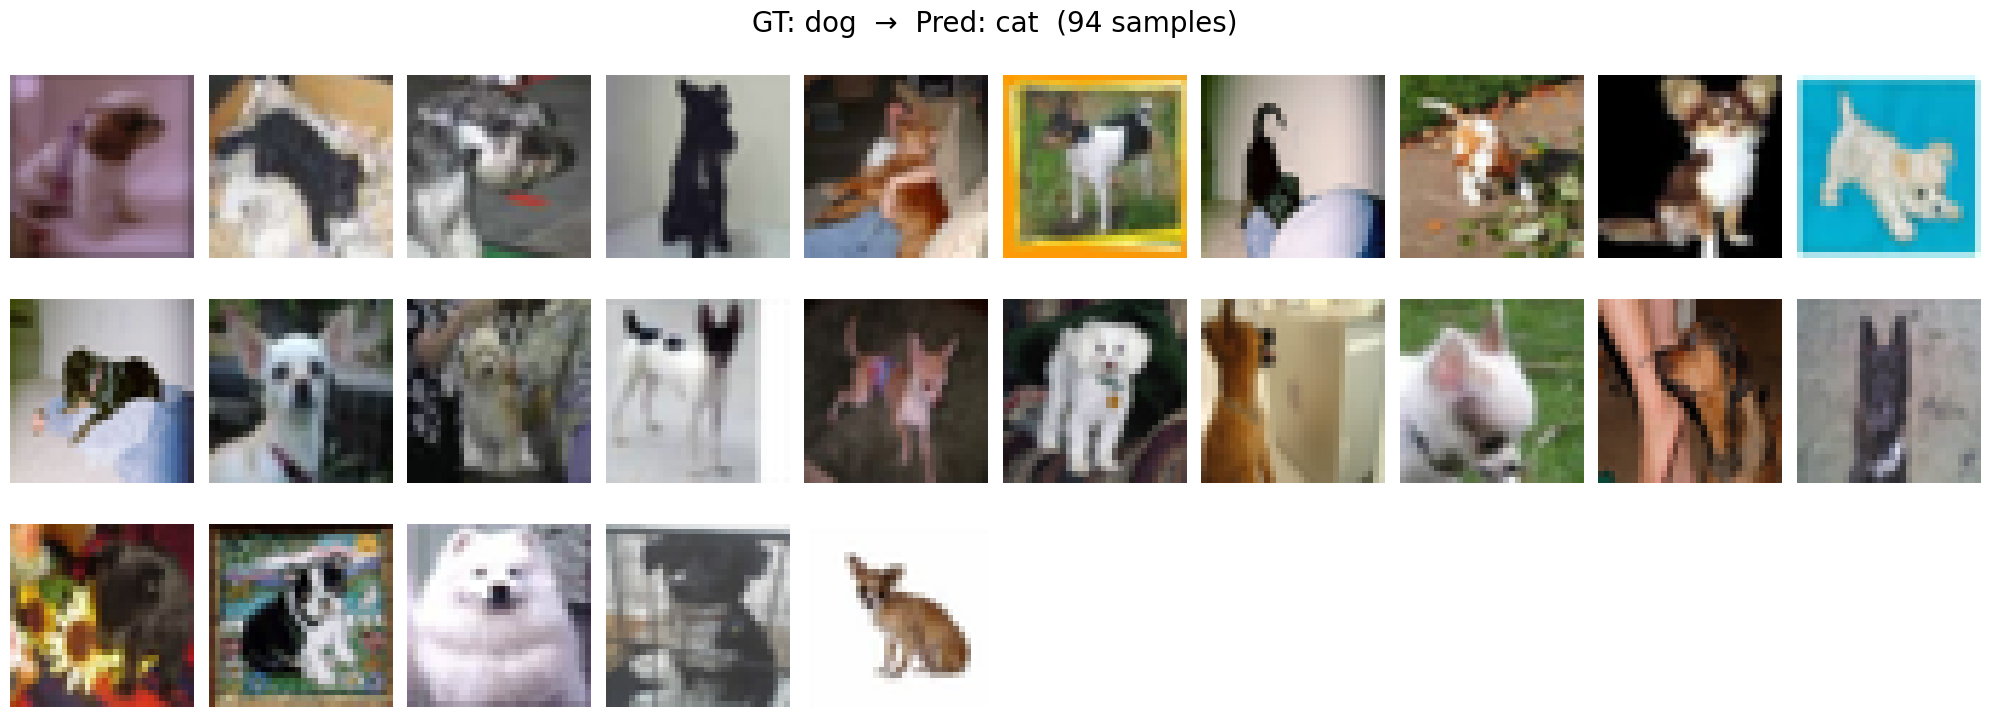

[Rank 2] True=truck, Pred=car → 48 misclassified samples


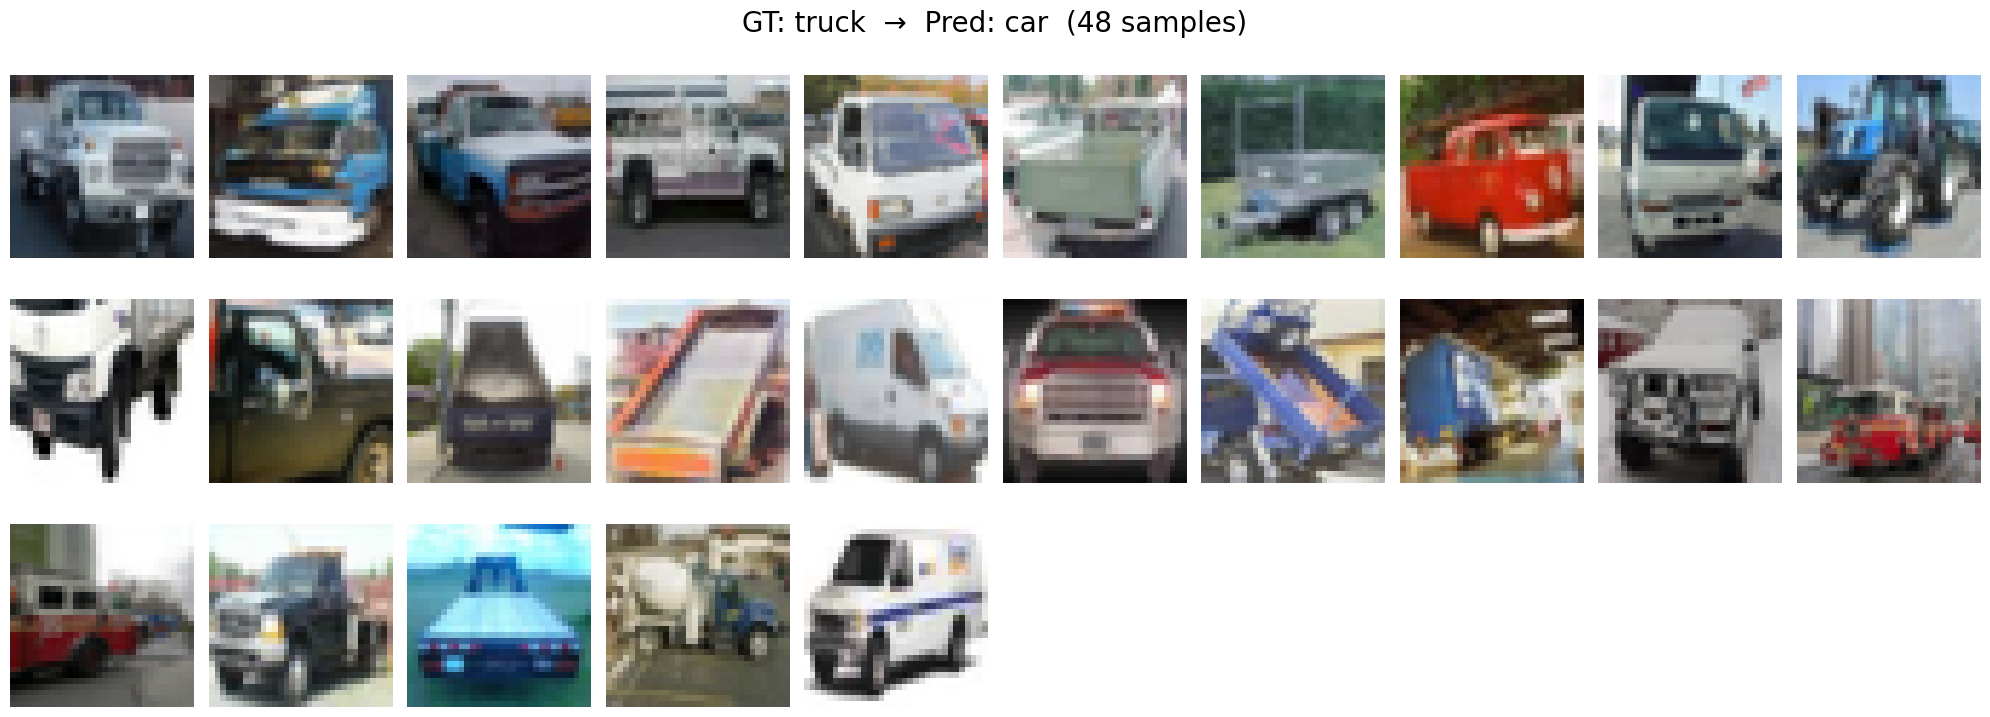

[Rank 3] True=cat, Pred=dog → 39 misclassified samples


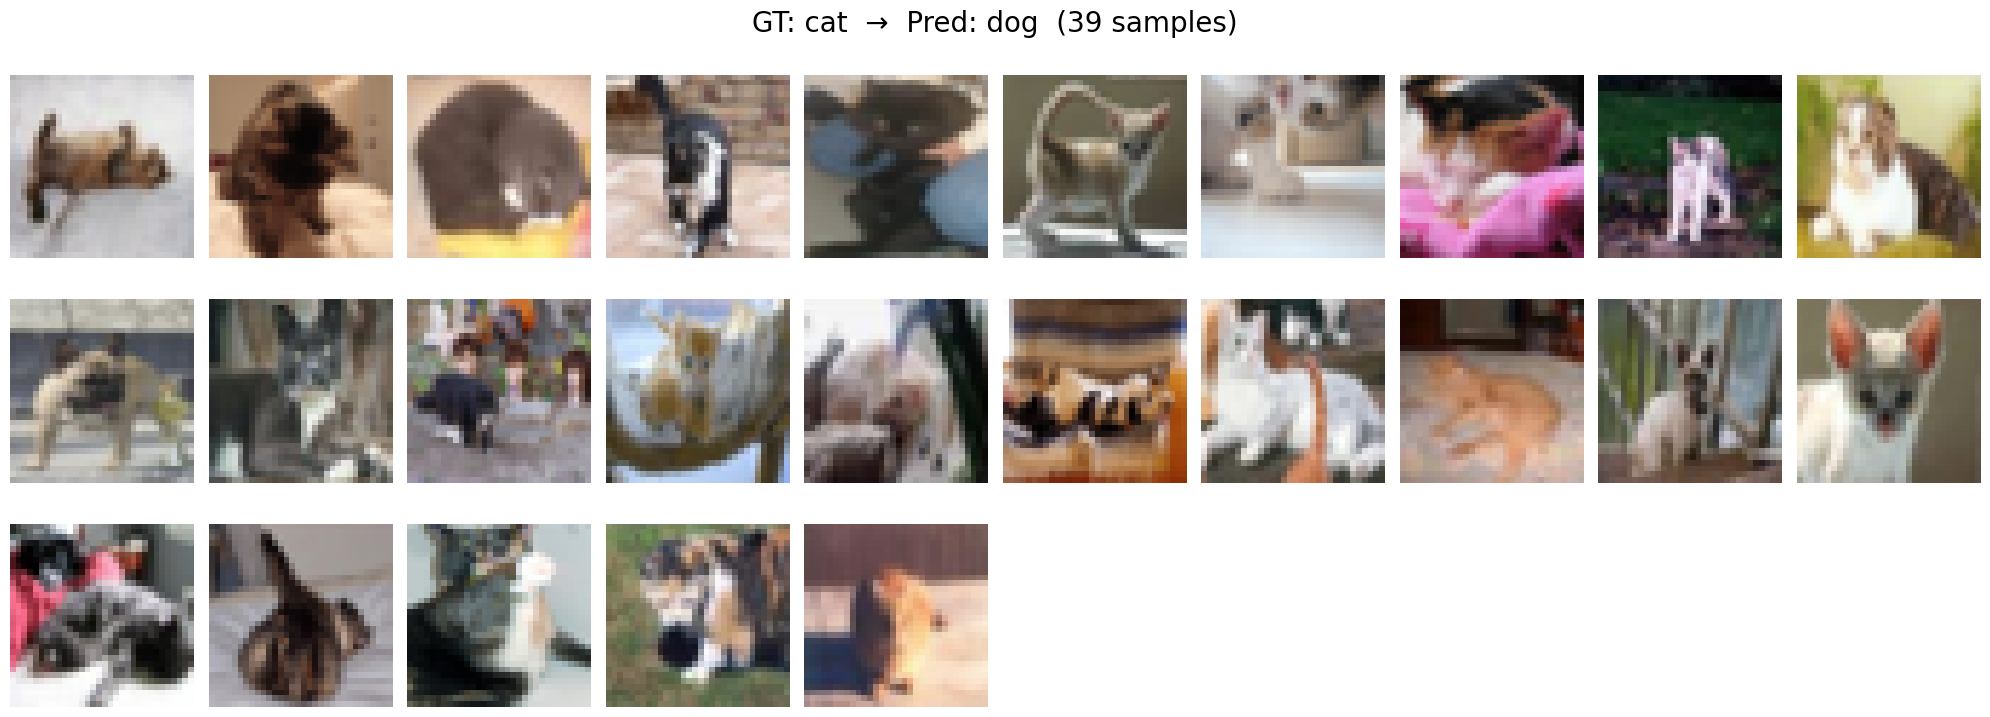

[Rank 4] True=frog, Pred=cat → 27 misclassified samples


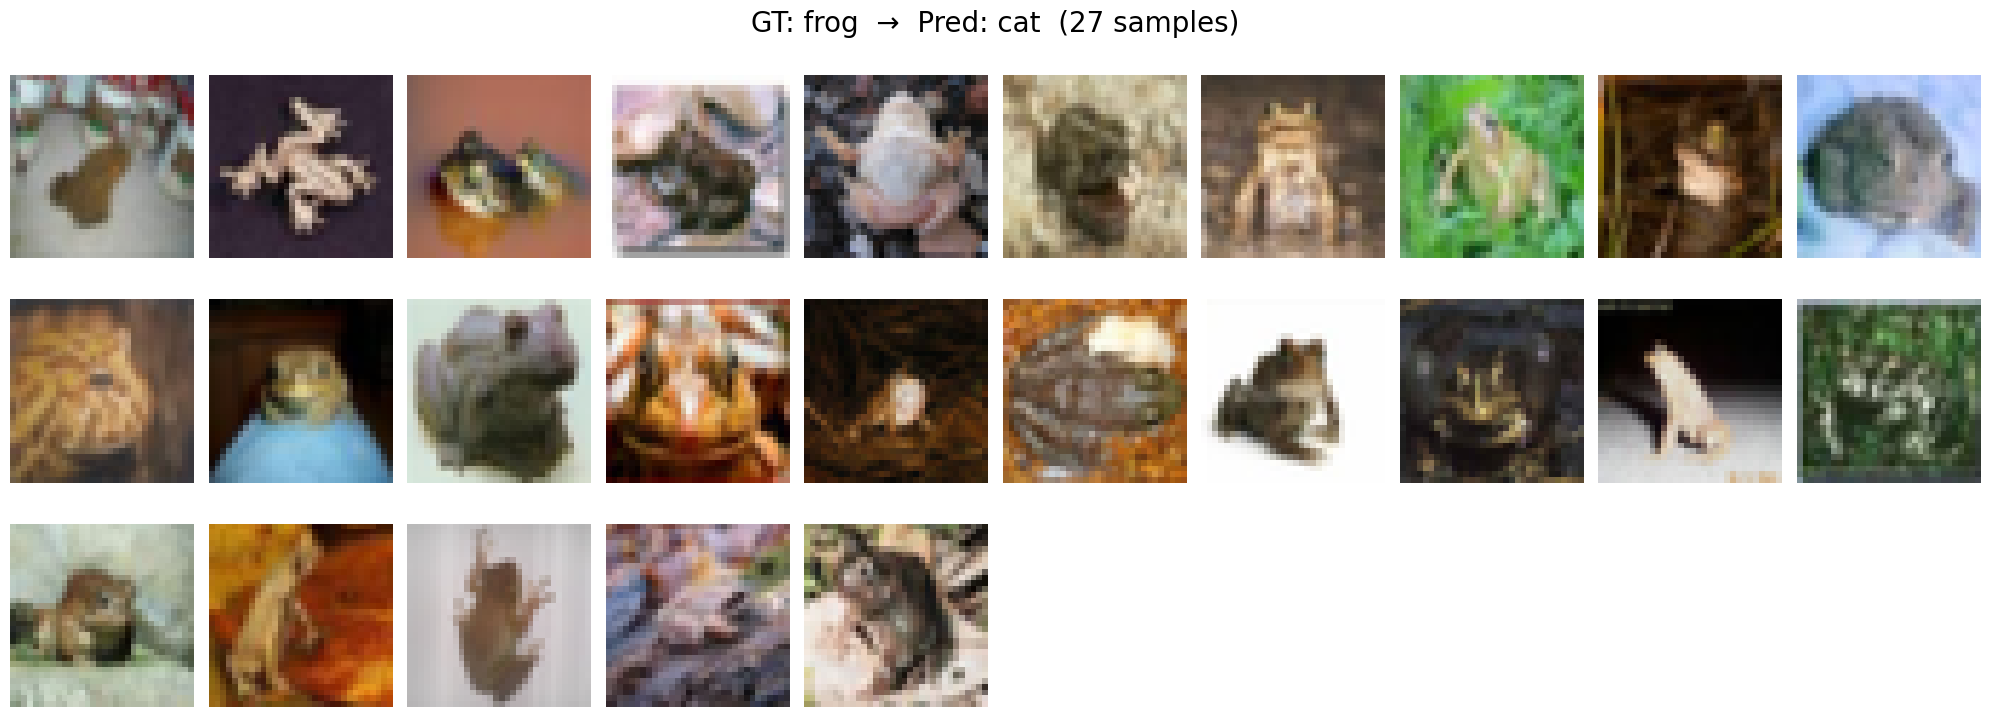

[Rank 5] True=deer, Pred=cat → 21 misclassified samples


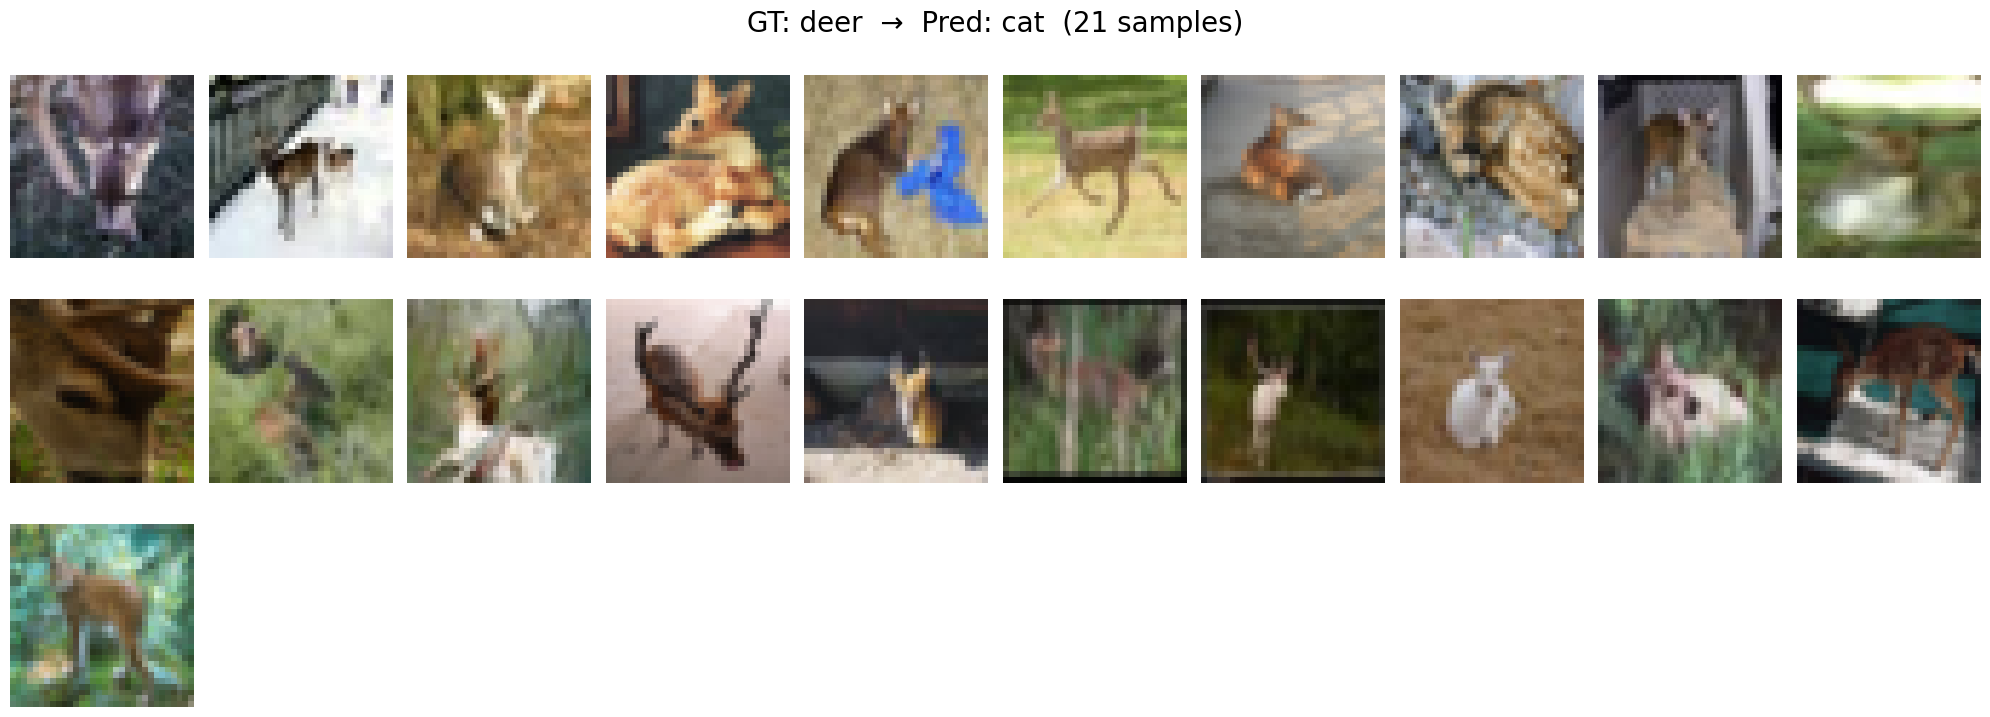

[Rank 6] True=plane, Pred=bird → 17 misclassified samples


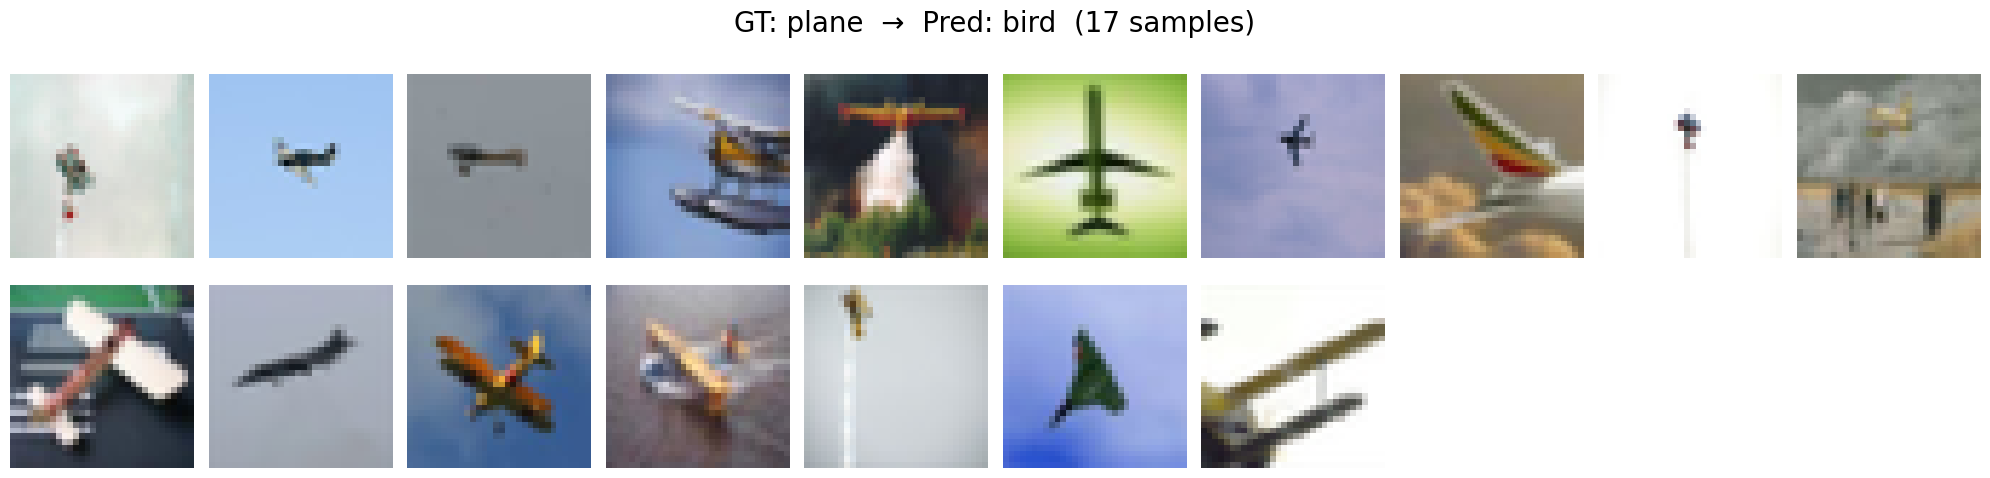

[Rank 7] True=bird, Pred=cat → 17 misclassified samples


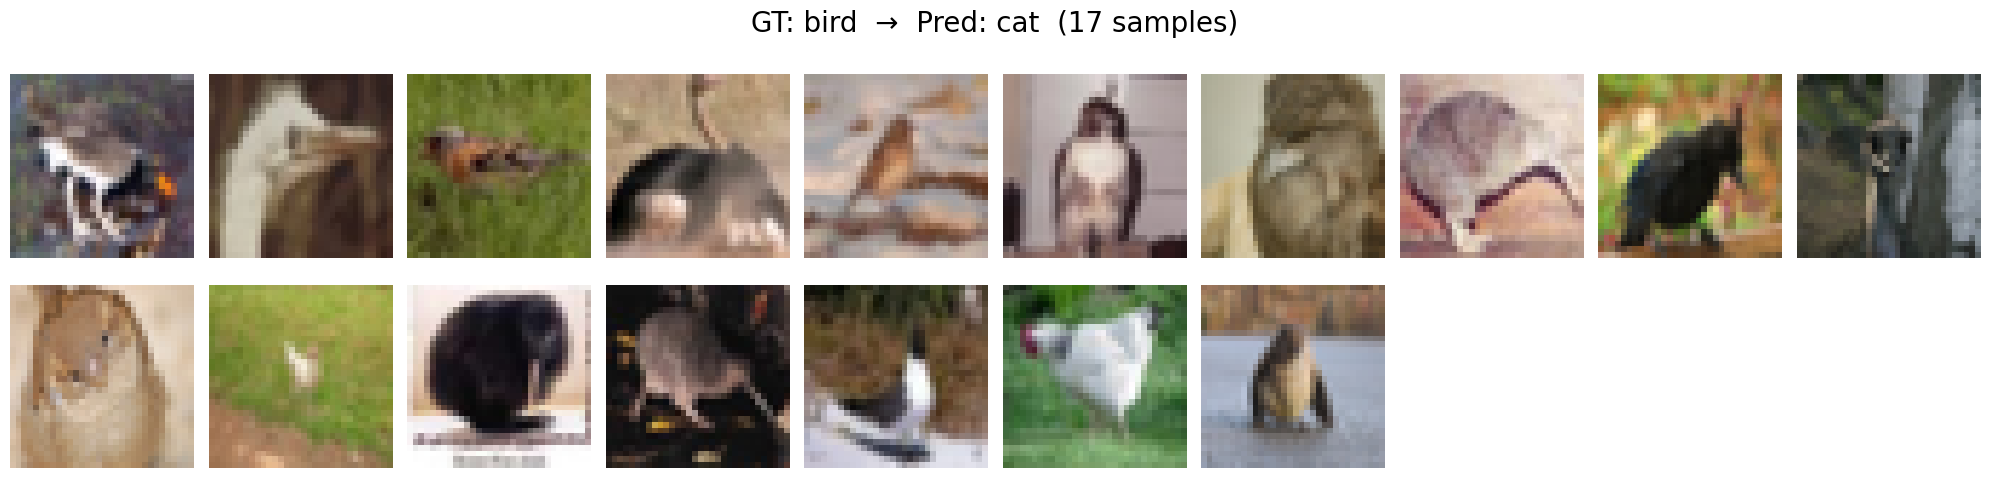

[Rank 8] True=plane, Pred=ship → 15 misclassified samples


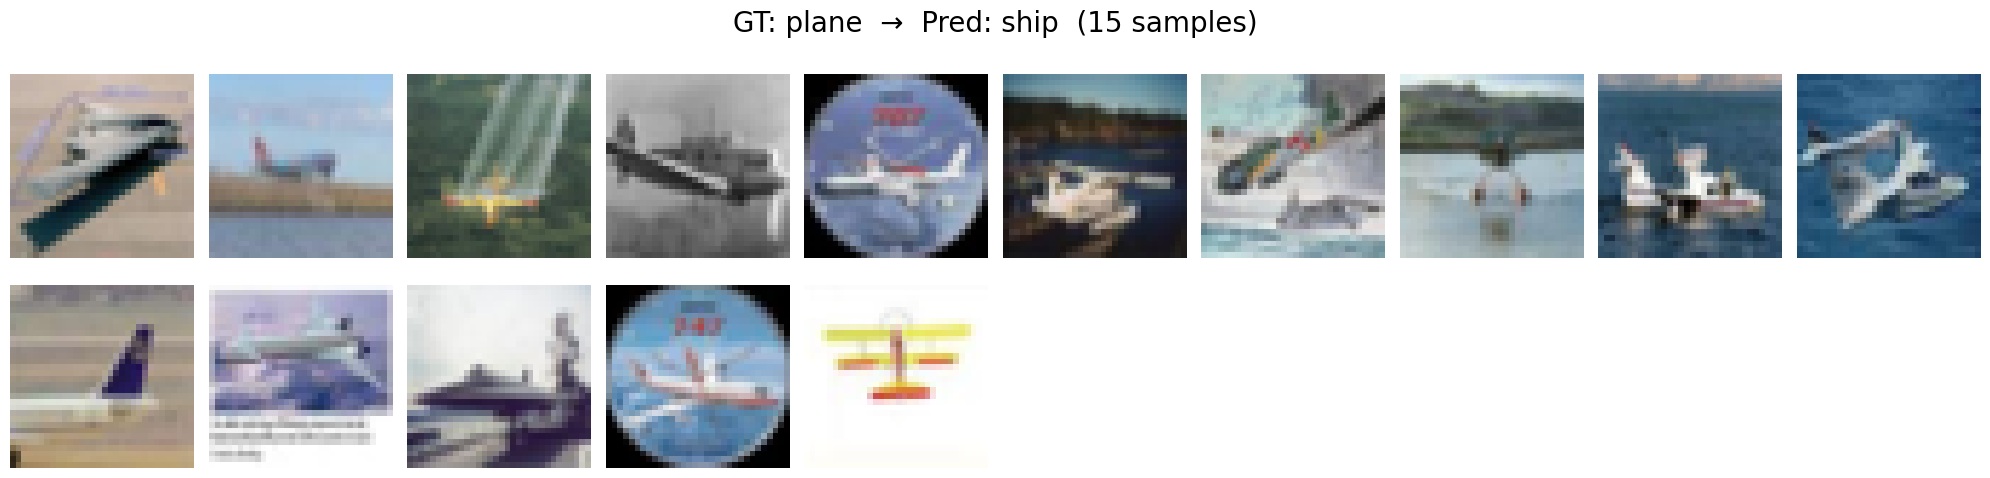

[Rank 9] True=frog, Pred=bird → 12 misclassified samples


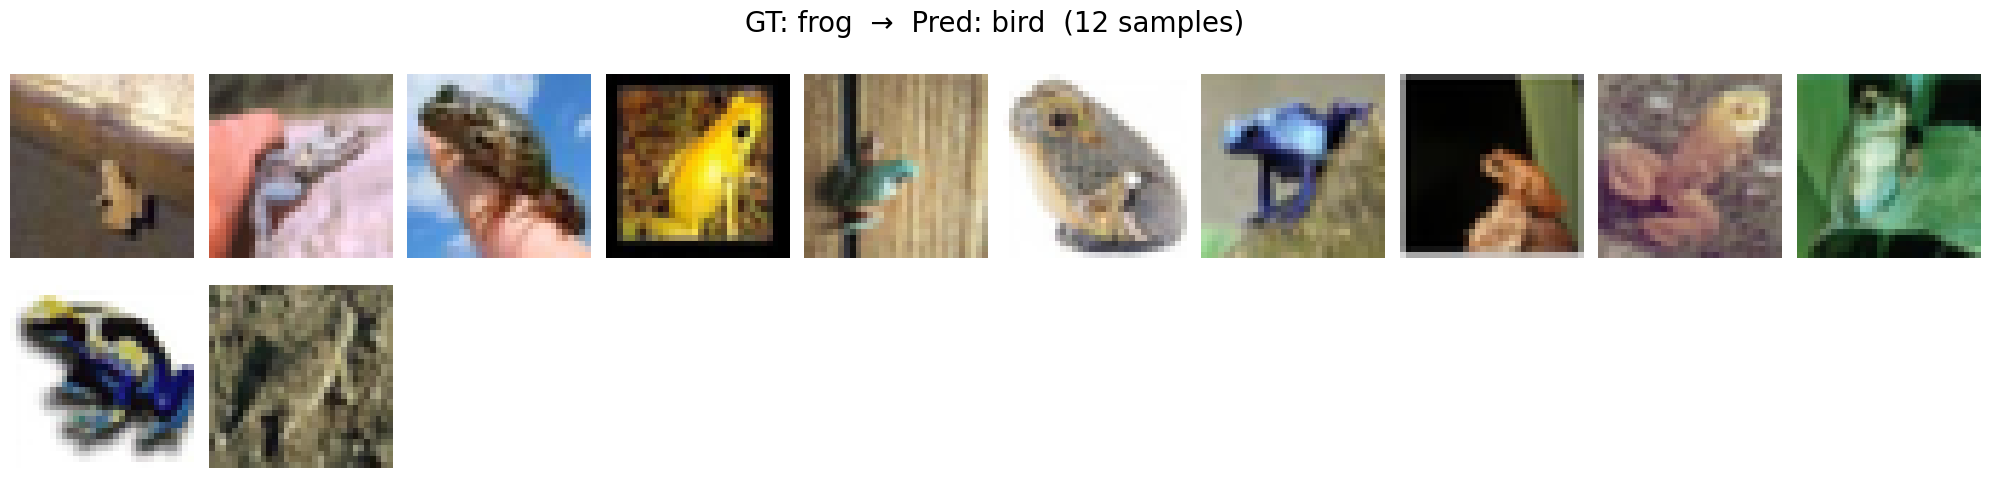

[Rank 10] True=bird, Pred=deer → 11 misclassified samples


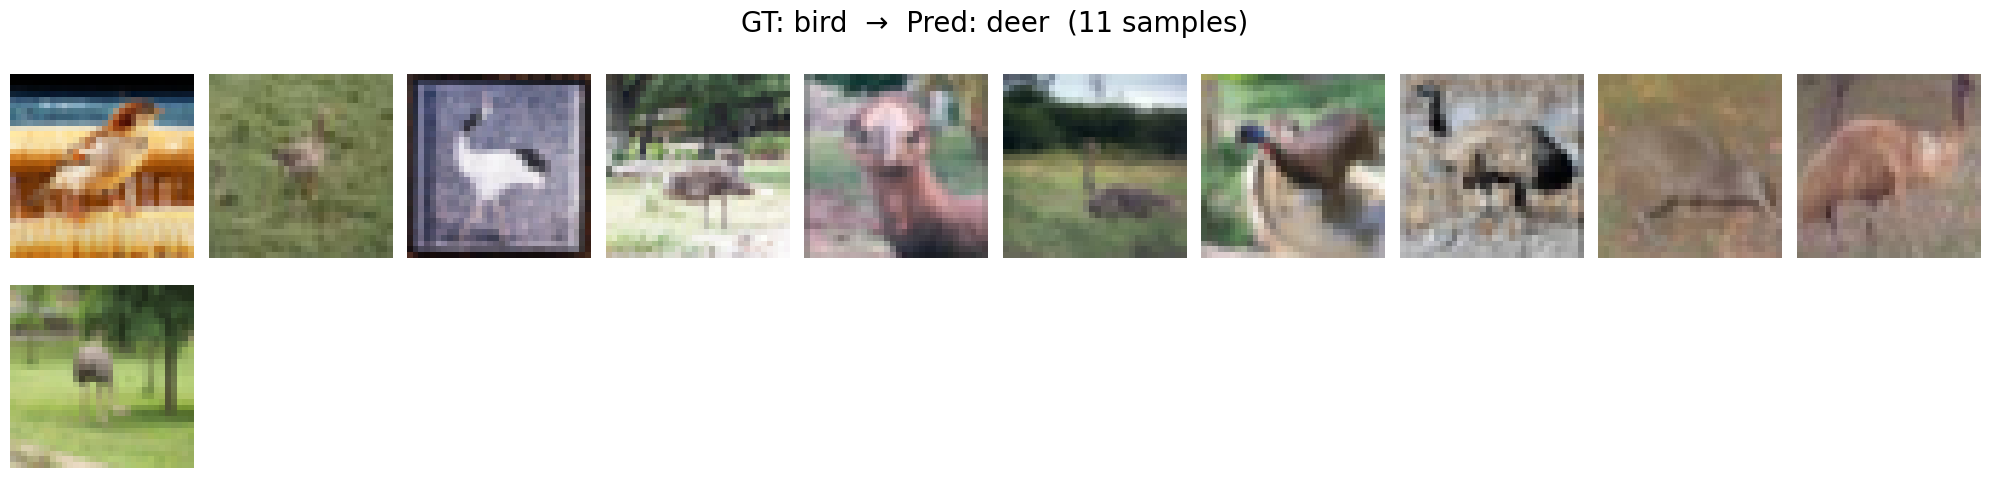

In [ ]:
def show_top_misclassification_pairs(dataset, y_true, y_pred, classes, max_pairs=10, max_images=25):

    conf_mat = confusion_matrix(y_true, y_pred)
    num_classes = len(classes)

    # 対角成分（正解）以外のミスだけをスコアにする
    misclassified_scores = []
    for gt in range(num_classes):
        for pr in range(num_classes):
            if gt != pr:
                misclassified_scores.append((gt, pr, conf_mat[gt, pr]))

    # 出現数が多い順に並べる
    top_pairs = sorted(misclassified_scores, key=lambda x: x[2], reverse=True)[:max_pairs]

    for idx, (gt, pr, count) in enumerate(top_pairs):
        indices = np.where((y_true == gt) & (y_pred == pr))[0]
        n = min(len(indices), max_images)
        rows = (n + 9) // 10

        print(f"[Rank {idx+1}] True={classes[gt]}, Pred={classes[pr]} → {count} misclassified samples")

        if n == 0:
            continue

        plt.figure(figsize=(20, 2.5 * rows))
        for i in range(n):
            img, _ = dataset[indices[i]]
            plt.subplot(rows, 10, i + 1)
            plt.imshow(np.asarray(img))
            plt.axis("off")
        plt.suptitle(f"GT: {classes[gt]}  →  Pred: {classes[pr]}  ({count} samples)", fontsize=20)
        plt.tight_layout()
        plt.show()

show_top_misclassification_pairs(raw_dataset, y_true, y_pred, classes, max_pairs=10, max_images=25)